<a href="https://colab.research.google.com/github/yashchauhan2910/Geoscience-with-Integrated-Data-Science---Heriot-Watt/blob/main/KMeans_Clustering_for_Well_Data_Yash_Singh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***
created by **Farah Rabie** (f.rabie@hw.ac.uk)
***

#### Introduction

<p>In this notebook, we <b>explore how to apply KMeans clustering to well log data</b>. KMeans clustering is an unsupervised Machine Learning algorithm. The goal is to group similar sections of well log data, in efforts to uncover patterns or clusters that may correlate with different lithologies.

<p>As a reminder, we have well log data from 7 wells in the Volve field. In this notebook, we will work with the data in four steps:</p>
<ul>
    <li><b>Process</b> the data</b>: This includes addressing data anomalies and scaling the data.</li>
    <li><b>Apply</b> the KMeans algorithm to group the data into clusters.</li>
    This includes tuning <em>k</em>, a hyperparameter corresponding to the number of clusters.
    <li><b>Visualise</b> the clusters and compare them with true lithology.</li>
</ul>

We start with cloning the `GeosciencePlusAI` GitHub repository so we can access the data and modules needed for the notebook.

In [ ]:
!rm -rf GeosciencePlusAI # If you're getting a fatal error here, try Runtime > Disconnect and delete runtime, then try Runtime > Run all
!git clone https://github.com/farah-rabie/GeosciencePlusAI.git

Cloning into 'GeosciencePlusAI'...
remote: Enumerating objects: 705, done.
remote: Counting objects: 100% (315/315), done.
remote: Compressing objects: 100% (208/208), done.
remote: Total 705 (delta 254), reused 107 (delta 107), pack-reused 390 (from 2)
Receiving objects: 100% (705/705), 131.70 MiB | 31.60 MiB/s, done.
Resolving deltas: 100% (398/398), done.
Updating files: 100% (52/52), done.


#### I$\,\,\,\,\,\,$Data Processing for Clustering

<p>We start off with processing the well log data. The <code>DataProcessing</code> class is imported from the <code>Lib.ClusteringFunctions</code> module and instantiated as <code>DataProcess.</code> This gives us access to functions for processing, scaling, and visualising well data.</p>

In [ ]:
from GeosciencePlusAI.Lib.ClusteringFunctions import DataProcessing
DataProcess = DataProcessing()

<p>Using <code>process_well_data</code>, we can load well logs from multiple wells and process their data. This includes:
<ul>
    <li> Handling missing values - we will be removing them here.</li>
    <li> Applying a logarithmic transformation to KLOGH, the permeability log, and RT, the resistivity log.</li>
    <li> Limiting GR, the Gamma ray log, to values less than or equal to 150. </li>
</ul>

We start off with selecting our training wells, and storing them in `train_well_data_path`. We also need to identify which logs to process, and store them in `selected_columns_train`.

Make sure not to include the `LITHOLOGY` column in `selected_columns_train` - we are attempting to cluster the data with respect to its geophysical properties; the `LITHOLOGY` is the result you are trying to find.

In [ ]:
# List of wells:
#"/content/GeosciencePlusAI/Data/15_9-F-1 B.csv"
#"/content/GeosciencePlusAI/Data/15_9-F-4.csv"
#"/content/GeosciencePlusAI/Data/15_9-F-5.csv"
#"/content/GeosciencePlusAI/Data/15_9-F-11 B.csv"
#"/content/GeosciencePlusAI/Data/15_9-F-12.csv"
#"/content/GeosciencePlusAI/Data/15_9-F-14.csv"
#"/content/GeosciencePlusAI/Data/15_9-F-15 C.csv"

In [ ]:
#train_well_data_path = ["/content/GeosciencePlusAI/Data/15_9-F-4.csv","/content/GeosciencePlusAI/Data/15_9-F-1 B.csv", "/content/GeosciencePlusAI/Data/15_9-F-11 B.csv", "/content/GeosciencePlusAI/Data/15_9-F-12.csv", "/content/GeosciencePlusAI/Data/15_9-F-15 C.csv"]
#test_well_data_path = ["/content/GeosciencePlusAI/Data/15_9-F-5.csv", "/content/GeosciencePlusAI/Data/15_9-F-14.csv" ]

In [ ]:
train_well_data_path = ["/content/GeosciencePlusAI/Data/15_9-F-4.csv","/content/GeosciencePlusAI/Data/15_9-F-1 B.csv", "/content/GeosciencePlusAI/Data/15_9-F-11 B.csv", "/content/GeosciencePlusAI/Data/15_9-F-12.csv", "/content/GeosciencePlusAI/Data/15_9-F-15 C.csv"]
selected_columns_train = ['BVW', 'KLOGH', 'VSH', 'GR', 'NPHI', 'RHOB', 'RT'] # 'DT' and 'PEF' data were excluded

<p>In addition to cleaning the data, <code>process_well_data</code> also computes the scaling parameters. We scale the data to try and give all logs the same weight. Scaling parameters are computed on training data. To signal this as training data, <code>train_data</code> in <code>process_well_data</code> must be set to <code>True</code>. This prompts <code>process_well_data</code> to combine the data into a single DataFrame, and compute the scaling parameters for the different logs.

There are two different methods for scaling the data:
<ul>
  <li>setting `method` in <code>process_well_data</code> to `minmax_01` computes normalisation parameters</li>
  <li>setting method` in <code>process_well_data</code> to `standard` computes standardisation parameters.</li>
</ul>

The descriptive statistics and first few rows of the processed data can be displayed by setting <code>show_stats</code> and <code>show_rows</code> to <code>True,</code> respectively. This give us a snapshot of the cleaned data. </p>

In [ ]:
processed_train_well_data = DataProcess.process_well_data(train_well_data_path, selected_columns_train, method = 'standard', train_data = True, show_stats = True, show_rows = True)


Descriptive Statistics of Data:
                BVW           VSH            GR          NPHI          RHOB  \
count  22699.000000  22699.000000  22699.000000  22699.000000  22699.000000   
mean       0.060767      0.287592     42.136206      0.191152      2.388510   
std        0.051522      0.192474     25.602711      0.058304      0.170156   
min        0.000000      0.000000      5.616400      0.000000      1.334100   
25%        0.026500      0.128000     21.254500      0.159000      2.238000   
50%        0.048100      0.246000     36.116500      0.184000      2.380000   
75%        0.082000      0.393000     56.629201      0.217000      2.519000   
max        1.000000      1.000000    149.932693      0.732400      3.201300   

          log_KLOGH        log_RT  
count  22699.000000  22699.000000  
mean       2.979613      2.487511  
std        2.799690      1.976011  
min        0.000000      0.107598  
25%        0.127381      1.099945  
50%        2.214628      1.770042  
75%

<p>When <code>train_data</code> is set to <code>False</code>, the data is considered testing data. In that case, <code>process_well_data</code> does not compute scaling parameters. It alse keeps the data for each well separate, in individual DataFrames. This is useful for independent testing.</p>

<p><b>❓Question</b></p>
<p>Notice how we include DEPTH and LITHOLOGY here. Why is that the case?</p>

In [ ]:
selected_columns_test = ['DEPTH', 'BVW', 'KLOGH', 'VSH', 'GR', 'NPHI', 'RHOB', 'RT', 'LITHOLOGY'] # 'DT' and 'PEF' data were excluded, 'DEPTH' and 'LITHOLOGY' have to be included here for visualisation

test_well_data_path = ["/content/GeosciencePlusAI/Data/15_9-F-5.csv", "/content/GeosciencePlusAI/Data/15_9-F-14.csv" ]
processed_test_well_data = DataProcess.process_well_data(test_well_data_path, selected_columns_test, train_data=False, show_stats=True, show_rows=False)


Descriptive Statistics of DataFrame 1:
             DEPTH          BVW          VSH           GR         NPHI  \
count  3290.000000  3290.000000  3290.000000  3290.000000  3290.000000   
mean   3512.250128     0.061356     0.420210    57.247449     0.208558   
std     147.683933     0.038671     0.256742    36.273304     0.066493   
min    3248.869698     0.000000     0.057700    11.630000     0.054800   
25%    3388.658877     0.030100     0.217300    29.957600     0.167300   
50%    3513.970028     0.057050     0.335200    43.553350     0.199950   
75%    3639.281179     0.090400     0.635875    78.608723     0.244875   
max    3766.268733     0.192400     1.000000   149.294403     0.597300   

              RHOB    log_KLOGH       log_RT  
count  3290.000000  3290.000000  3290.000000  
mean      2.419182     1.879632     1.976249  
std       0.159396     2.400840     1.282299  
min       2.130300     0.000000     0.294831  
25%       2.269500     0.001000     1.039455  
50%       2

<p> Next, we scale the data. The processed training well data is scaled using <code>scale_dataframe</code>. This scales the well logs based on previously computed scaling parameters. Setting <code>show_stats</code> to <code>True</code> displays descriptive statistics of the scaled data if the.</p>

In [ ]:
standardised_train_well_data = DataProcess.scale_dataframe(processed_train_well_data, show_stats = True)


Scaling Method: standard
Scaling Parameters:
BVW: {'mean': 0.060767138954183016, 'std': 0.05152169343352859}
VSH: {'mean': 0.2875919550314111, 'std': 0.19247407164960326}
GR: {'mean': 42.13620593249112, 'std': 25.602710889787016}
NPHI: {'mean': 0.19115240701903166, 'std': 0.05830365489076212}
RHOB: {'mean': 2.388510308330279, 'std': 0.17015627055204352}
log_KLOGH: {'mean': 2.9796131496236957, 'std': 2.7996902685589222}
log_RT: {'mean': 2.4875105947857845, 'std': 1.9760114382318674}


<br>We must also scale the testing data.

In [ ]:
standardised_test_well_data = [] #lets make an empty list for each dataframe under testing well

for df in processed_test_well_data:
  standardised_df = DataProcess.scale_dataframe(df, show_stats = True)
  standardised_test_well_data.append(standardised_df)


Scaling Method: standard
Scaling Parameters:
BVW: {'mean': 0.060767138954183016, 'std': 0.05152169343352859}
VSH: {'mean': 0.2875919550314111, 'std': 0.19247407164960326}
GR: {'mean': 42.13620593249112, 'std': 25.602710889787016}
NPHI: {'mean': 0.19115240701903166, 'std': 0.05830365489076212}
RHOB: {'mean': 2.388510308330279, 'std': 0.17015627055204352}
log_KLOGH: {'mean': 2.9796131496236957, 'std': 2.7996902685589222}
log_RT: {'mean': 2.4875105947857845, 'std': 1.9760114382318674}

Scaling Method: standard
Scaling Parameters:
BVW: {'mean': 0.060767138954183016, 'std': 0.05152169343352859}
VSH: {'mean': 0.2875919550314111, 'std': 0.19247407164960326}
GR: {'mean': 42.13620593249112, 'std': 25.602710889787016}
NPHI: {'mean': 0.19115240701903166, 'std': 0.05830365489076212}
RHOB: {'mean': 2.388510308330279, 'std': 0.17015627055204352}
log_KLOGH: {'mean': 2.9796131496236957, 'std': 2.7996902685589222}
log_RT: {'mean': 2.4875105947857845, 'std': 1.9760114382318674}


<br>
<p>And with that, data processing is complete.

We can visualise and compare distributions of any log before and after scaling using <code>compare_distributions</code>. This can help us to assess how scaling has transformed the log. We want to ensure the logs follow a consistent scale while retaining the overall shape and characteristics of the original distribution.

We select GR in this example. <code>compare_distributions</code> plots its distribution for both the processed data (<code>processed_train_well_data</code>) and the scaled data (<code>standardised_train_well_data</code>). </p>

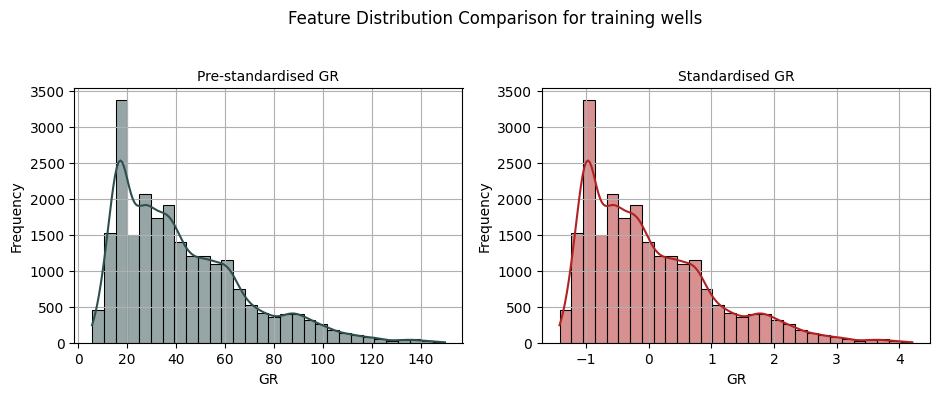

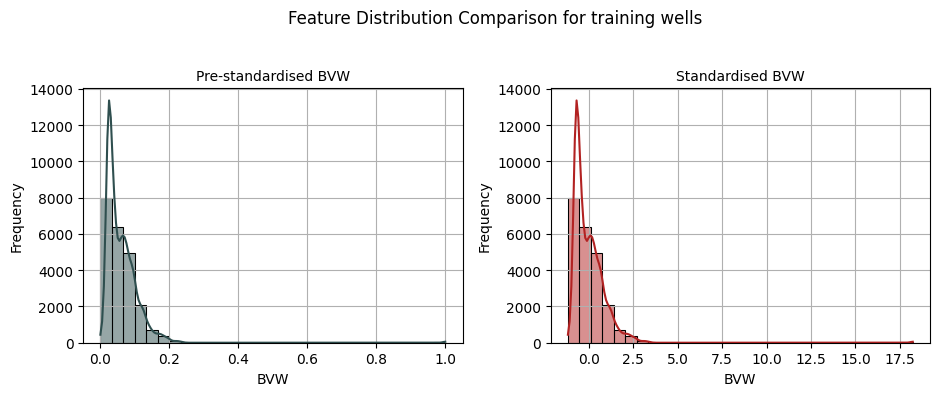

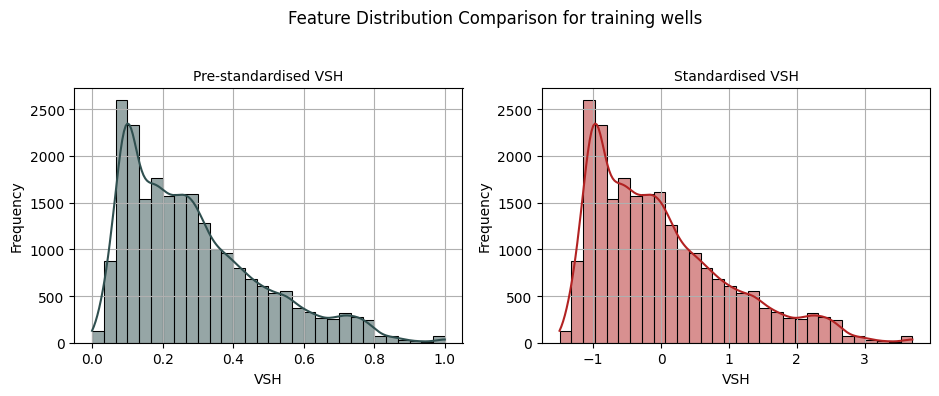

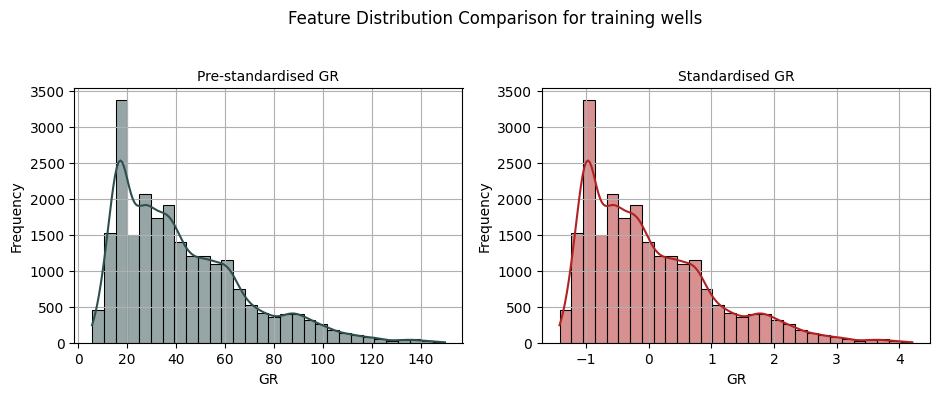

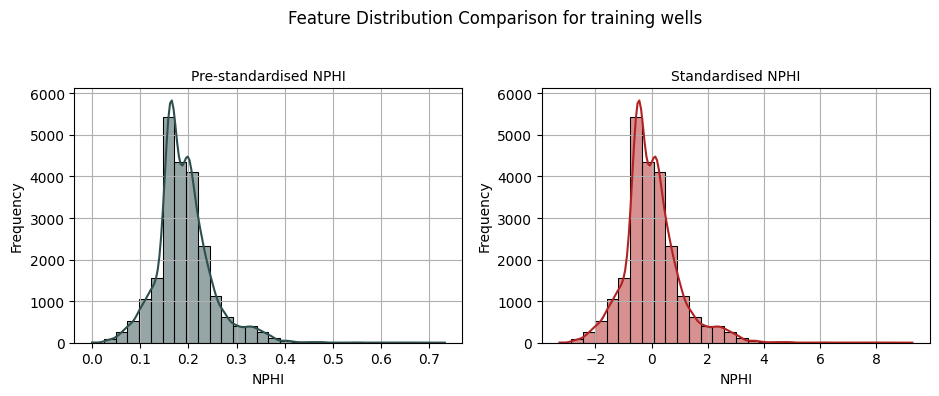

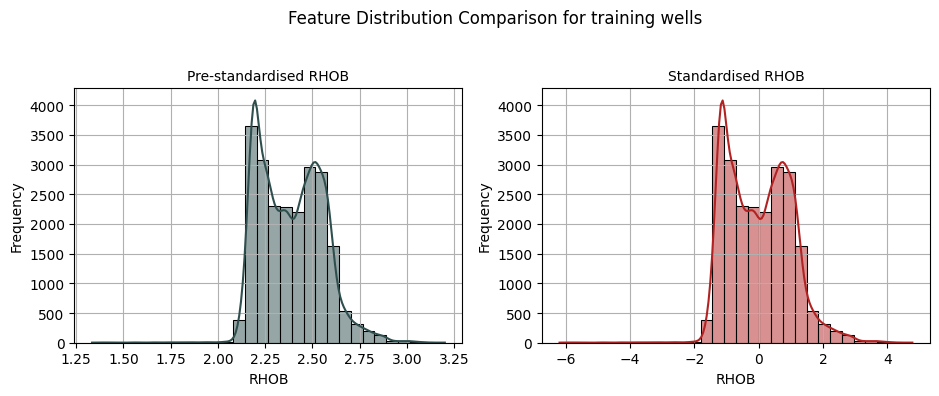

In [ ]:
curves = ['GR','BVW', 'VSH', 'GR', 'NPHI', 'RHOB']

for curve in curves:
  DataProcess.compare_distributions(processed_train_well_data, standardised_train_well_data, curve, title="Feature Distribution Comparison for training wells")

#DataProcess.compare_distributions(processed_train_well_data, standardised_train_well_data, 'GR')
# Options: 'BVW', 'KLOGH', 'VSH', 'GR', 'NPHI', 'RHOB', 'RT'

#### II$\,\,\,\,\,\,$Choosing the Optimal Number of Clusters (Elbow Method)

<p>Next, we import the <code>KMeansClustering</code> class from the <code>ClusteringFunctions</code> module and create an instance of it, named <code>KMeans_Clustering</code>. This instance will be used to perform clustering tasks such as fitting the K-Means model, determining optimal cluster numbers, and analysing the results.</p>

In [ ]:
from GeosciencePlusAI.Lib.ClusteringFunctions import KMeansClustering
KMeans_Clustering = KMeansClustering()

<p>The <code>KMeans_Clustering.elbow_method</code> is used to determine the optimal number of clusters for the standardised training dataset (<code>standardised_train_well_data</code>). By varying the number of clusters (<code>k</code>) from 1 to 10, it calculates and plots the <em>inertia</em>, the sum of squared distances to the nearest cluster centroid. The resulting <em>elbow</em> plot helps identify the ideal number of clusters, where the inertia starts to decrease more slowly, indicating a balance between underfitting and overfitting.</p>

k: 1
inertia:  158886.00000000224
k: 2
inertia:  97381.6404212572
k: 3
inertia:  80880.24190087745
k: 4
inertia:  71072.65806705665
k: 5
inertia:  60766.11544378997
k: 6
inertia:  54048.99937632232
k: 7
inertia:  46627.56601575924
k: 8
inertia:  39866.07982391901
k: 9
inertia:  36243.528343286045
k: 10
inertia:  32713.93567808009


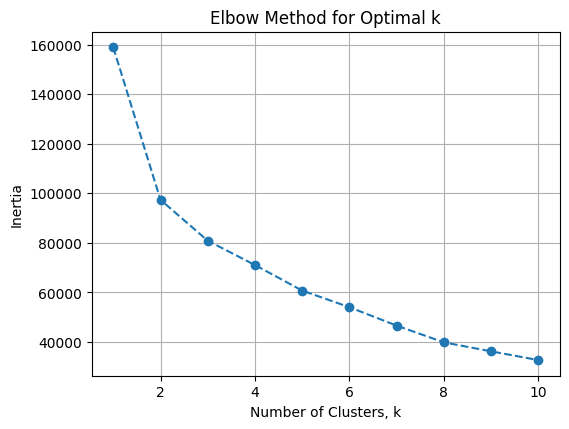

In [ ]:
KMeans_Clustering.elbow_method(standardised_train_well_data, max_k = 10)

##### III$\,\,\,\,\,\,$Applying K-Means Clustering to Well Log Data

<p>Now that we have standardised our well log data, we can proceed with applying the KMeans clustering algorithm. We will begin by training the model using the standardised training dataset. For this exercise, we specify the number of clusters, <code>n_clusters = 5</code>, based on our previous analysis of the elbow chart.</p>

<p>The <show_stats=True> option will provide us with useful performance metrics, such as the <em>inertia</em> and <em>silhouette score</em>, which help us assess the quality of our clustering.</p>

In [ ]:
train_clustered, kmeans_model = KMeans_Clustering.run_kmeans_train(standardised_train_well_data, n_clusters = 5, show_stats = True)

K-Means Clustering Results (Training Data) with 5 Clusters
Inertia (Sum of Squared Distances to Centroids): 60766.11544378997
Silhouette Score (Training Data): 0.3490


In [ ]:
test_clustered_1, kmeans_model = KMeans_Clustering.run_kmeans_train(standardised_test_well_data[0], n_clusters = 5, show_stats = True)

K-Means Clustering Results (Training Data) with 5 Clusters
Inertia (Sum of Squared Distances to Centroids): 5427.554686474938
Silhouette Score (Training Data): 0.3661


In [ ]:
test_clustered_2, kmeans_model = KMeans_Clustering.run_kmeans_train(standardised_test_well_data[1], n_clusters = 5, show_stats = True)

K-Means Clustering Results (Training Data) with 5 Clusters
Inertia (Sum of Squared Distances to Centroids): 8050.497349571205
Silhouette Score (Training Data): 0.4305


We can now use the trained KMeans model to predict the clusters for the first well in our training dataset.

In [ ]:
#train_well_data_path = ["/content/GeosciencePlusAI/Data/15_9-F-4.csv","/content/GeosciencePlusAI/Data/15_9-F-1 B.csv", "/content/GeosciencePlusAI/Data/15_9-F-11 B.csv", "/content/GeosciencePlusAI/Data/15_9-F-12.csv", "/content/GeosciencePlusAI/Data/15_9-F-15 C.csv"]
#test_well_data_path = ["/content/GeosciencePlusAI/Data/15_9-F-5.csv", "/content/GeosciencePlusAI/Data/15_9-F-14.csv" ]

In [ ]:
# train_well_data_path and selected_columns_test previously set
# train_data=False > even though this is training data, we want to process it as testing data so we can plot it

# for reference:
#standardised_train_singles_well_data
#"/content/GeosciencePlusAI/Data/15_9-F-4.csv" >> 0

#standardised_test_well_data
#"/content/GeosciencePlusAI/Data/15_9-F-5.csv" >> 0

standardised_train_singles_well_data = []
processed_train_singles_well_data = DataProcess.process_well_data(train_well_data_path, selected_columns_test, train_data = False, show_stats = False, show_rows = False)

for df in processed_train_singles_well_data:
  standardised_df = DataProcess.scale_dataframe(df, show_stats = True)
  standardised_train_singles_well_data.append(standardised_df)



Scaling Method: standard
Scaling Parameters:
BVW: {'mean': 0.060767138954183016, 'std': 0.05152169343352859}
VSH: {'mean': 0.2875919550314111, 'std': 0.19247407164960326}
GR: {'mean': 42.13620593249112, 'std': 25.602710889787016}
NPHI: {'mean': 0.19115240701903166, 'std': 0.05830365489076212}
RHOB: {'mean': 2.388510308330279, 'std': 0.17015627055204352}
log_KLOGH: {'mean': 2.9796131496236957, 'std': 2.7996902685589222}
log_RT: {'mean': 2.4875105947857845, 'std': 1.9760114382318674}

Scaling Method: standard
Scaling Parameters:
BVW: {'mean': 0.060767138954183016, 'std': 0.05152169343352859}
VSH: {'mean': 0.2875919550314111, 'std': 0.19247407164960326}
GR: {'mean': 42.13620593249112, 'std': 25.602710889787016}
NPHI: {'mean': 0.19115240701903166, 'std': 0.05830365489076212}
RHOB: {'mean': 2.388510308330279, 'std': 0.17015627055204352}
log_KLOGH: {'mean': 2.9796131496236957, 'std': 2.7996902685589222}
log_RT: {'mean': 2.4875105947857845, 'std': 1.9760114382318674}

Scaling Method: standar

In [ ]:
standardised_train_singles_well_data

[            DEPTH       BVW       VSH        GR      NPHI      RHOB  \
 0     3101.193802  0.998276  2.255930  2.897580  0.966450  0.501243   
 1     3101.346203  1.665956  2.257489  3.763656  1.697108  0.165669   
 22    3104.546609  1.745534  2.286064  4.206761  4.456798 -0.700006   
 205   3132.435865  1.128318  2.535968  4.210354  1.866909  0.309655   
 206   3132.588265  1.044858  2.537007  4.110135  1.858333  0.275568   
 ...           ...       ...       ...       ...       ...       ...   
 2580  3494.386589  0.777010  0.235398  0.513024 -0.992260  0.638764   
 2581  3494.538989  0.712959  0.207862  0.480457 -0.908218  0.663447   
 2582  3494.691389  0.701314  0.164220  0.429048 -1.100315  0.818011   
 2583  3494.843790  0.161735  0.179287  0.446468 -0.978539  0.826238   
 2584  3494.996190  0.107389  0.199030  0.470091 -1.038570  0.855035   
 
       LITHOLOGY  log_KLOGH    log_RT  
 0     Claystone  -1.063908 -0.805433  
 1     Claystone  -1.063908 -0.886913  
 22    Claysto

In [ ]:


train_clustered_1 = KMeans_Clustering.run_kmeans_test(standardised_train_singles_well_data[0], kmeans_model)
train_clustered_2 = KMeans_Clustering.run_kmeans_test(standardised_train_singles_well_data[1], kmeans_model)
train_clustered_3 = KMeans_Clustering.run_kmeans_test(standardised_train_singles_well_data[2], kmeans_model)
train_clustered_4 = KMeans_Clustering.run_kmeans_test(standardised_train_singles_well_data[3], kmeans_model)
train_clustered_5 = KMeans_Clustering.run_kmeans_test(standardised_train_singles_well_data[4], kmeans_model)


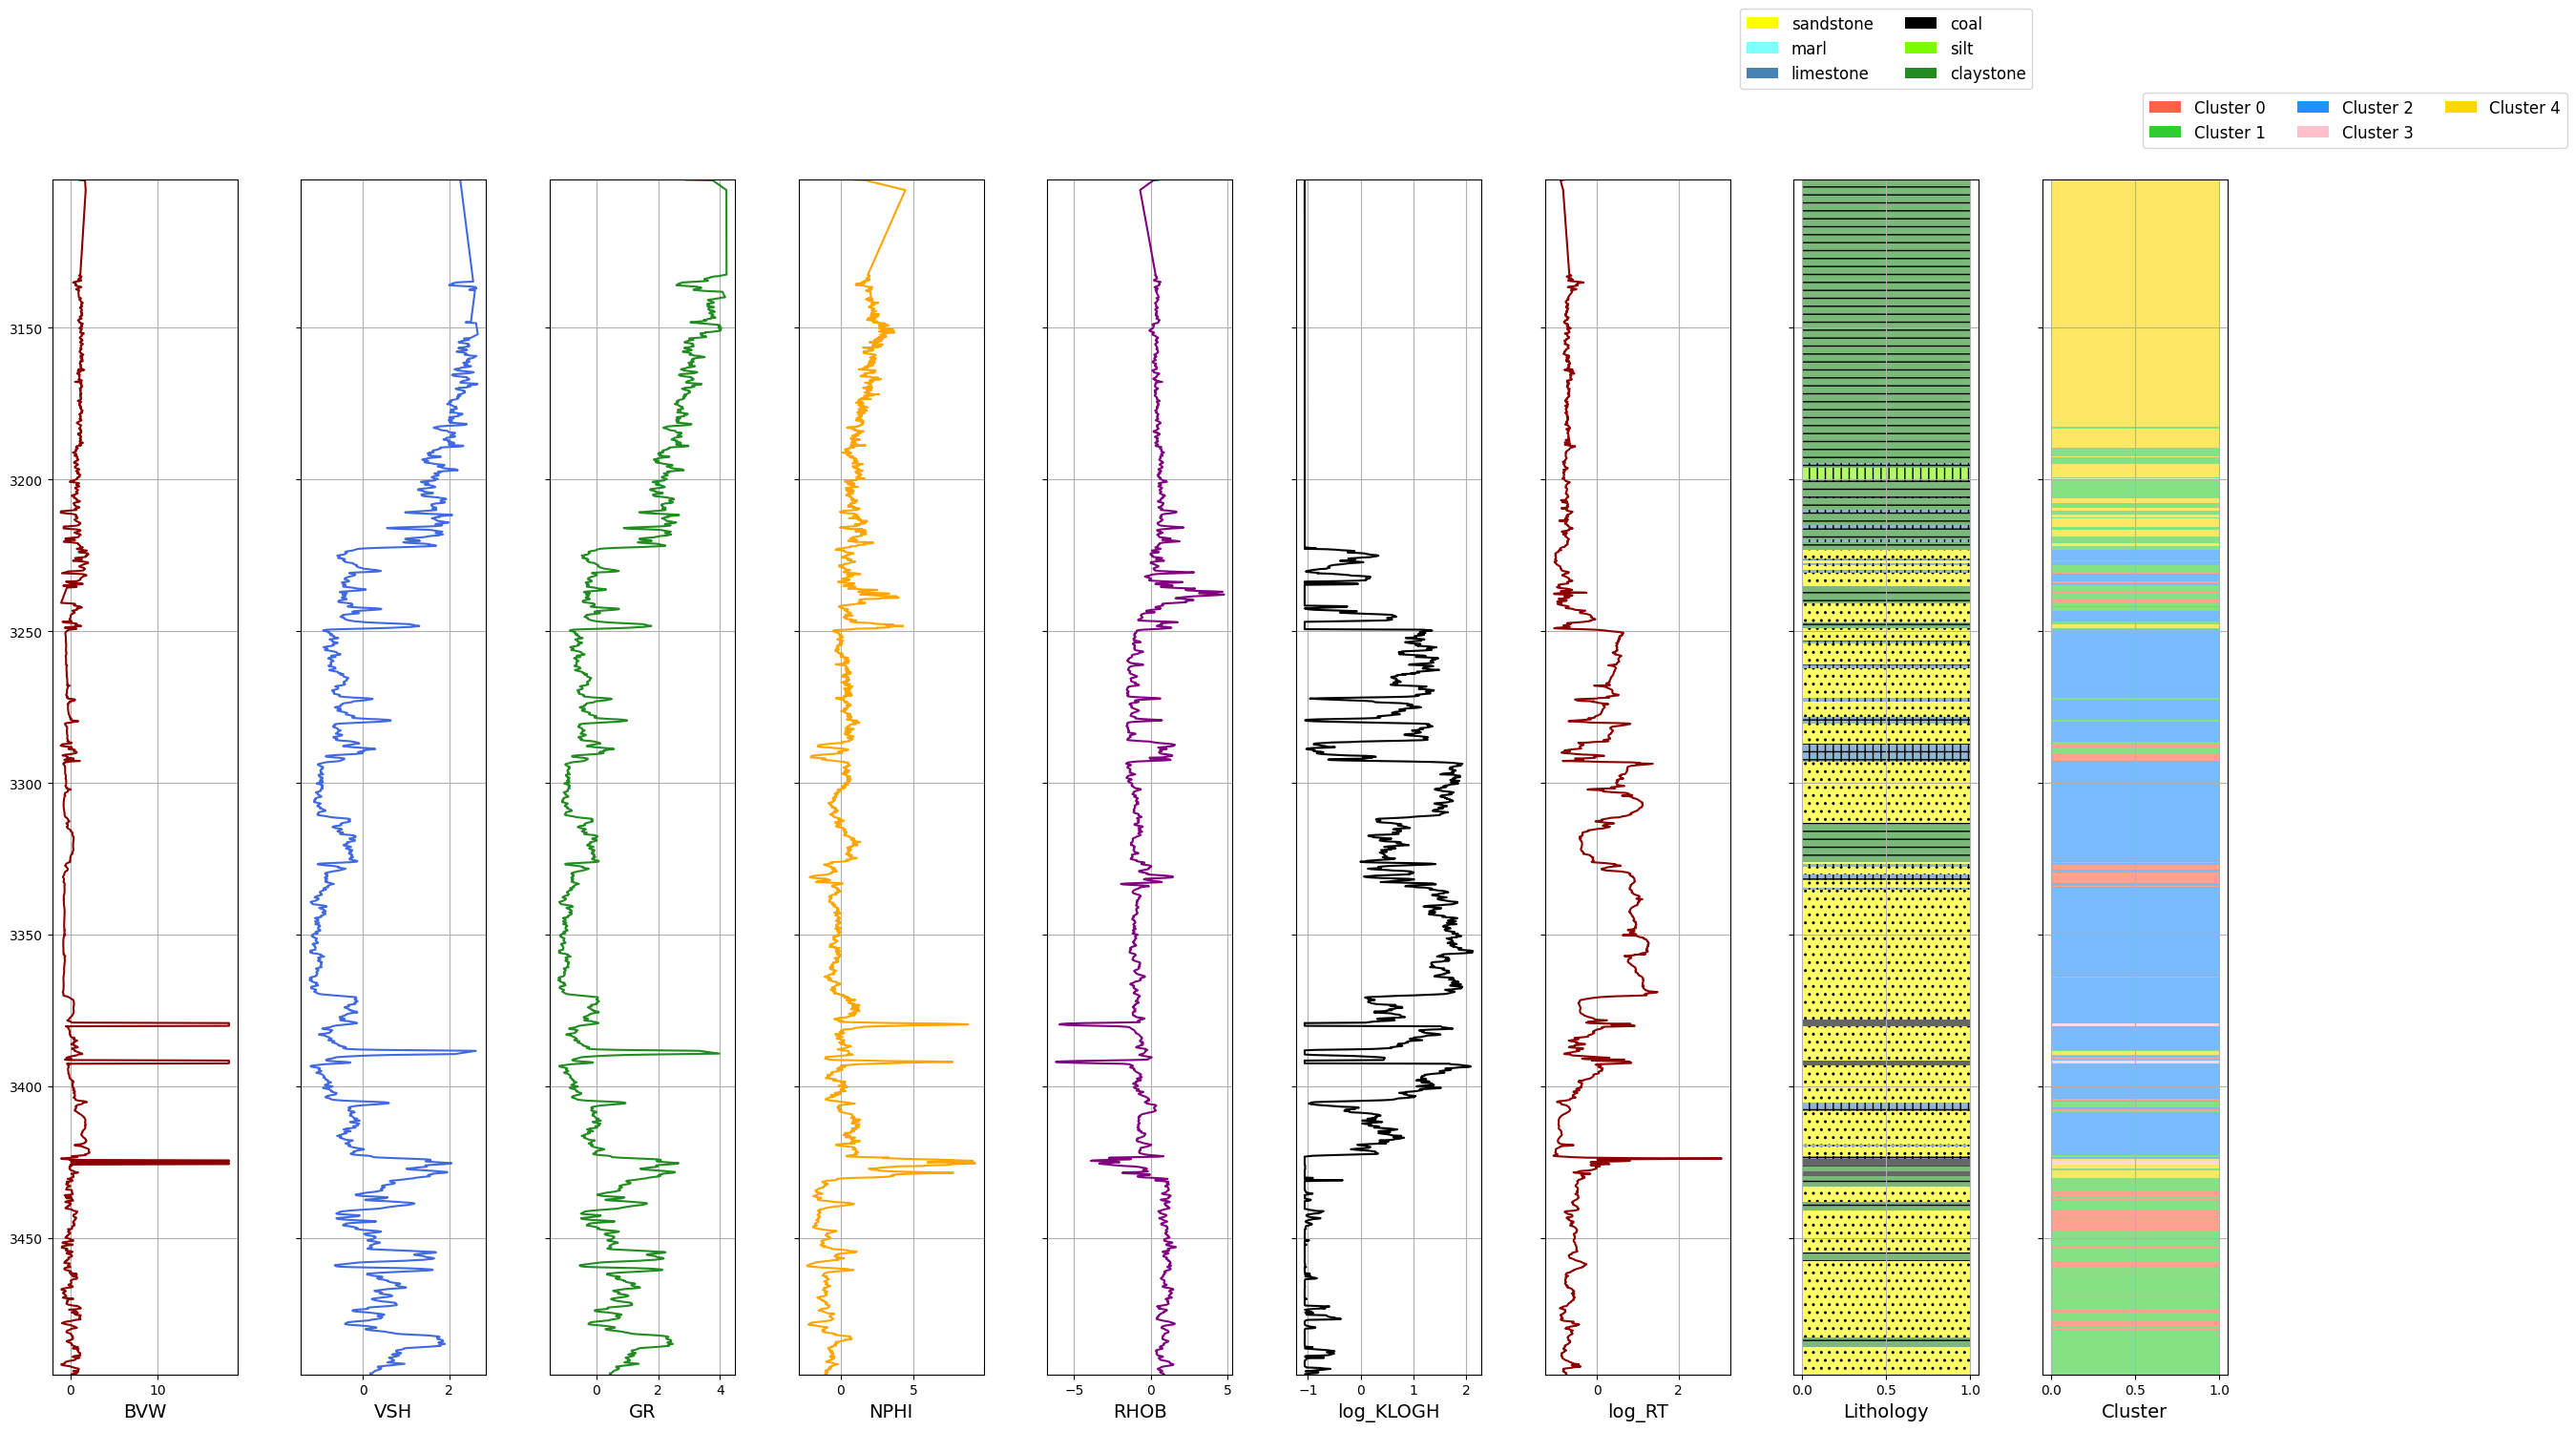

In [ ]:

column_names = train_clustered_1.columns.tolist()
column_names = [col for col in column_names if col != "DEPTH"]
column_names = [col for col in column_names if col != "Cluster"]
column_names = [col for col in column_names if col != "LITHOLOGY"]

KMeans_Clustering.visualise_lithology_clusters(train_clustered_1, log_columns=column_names)

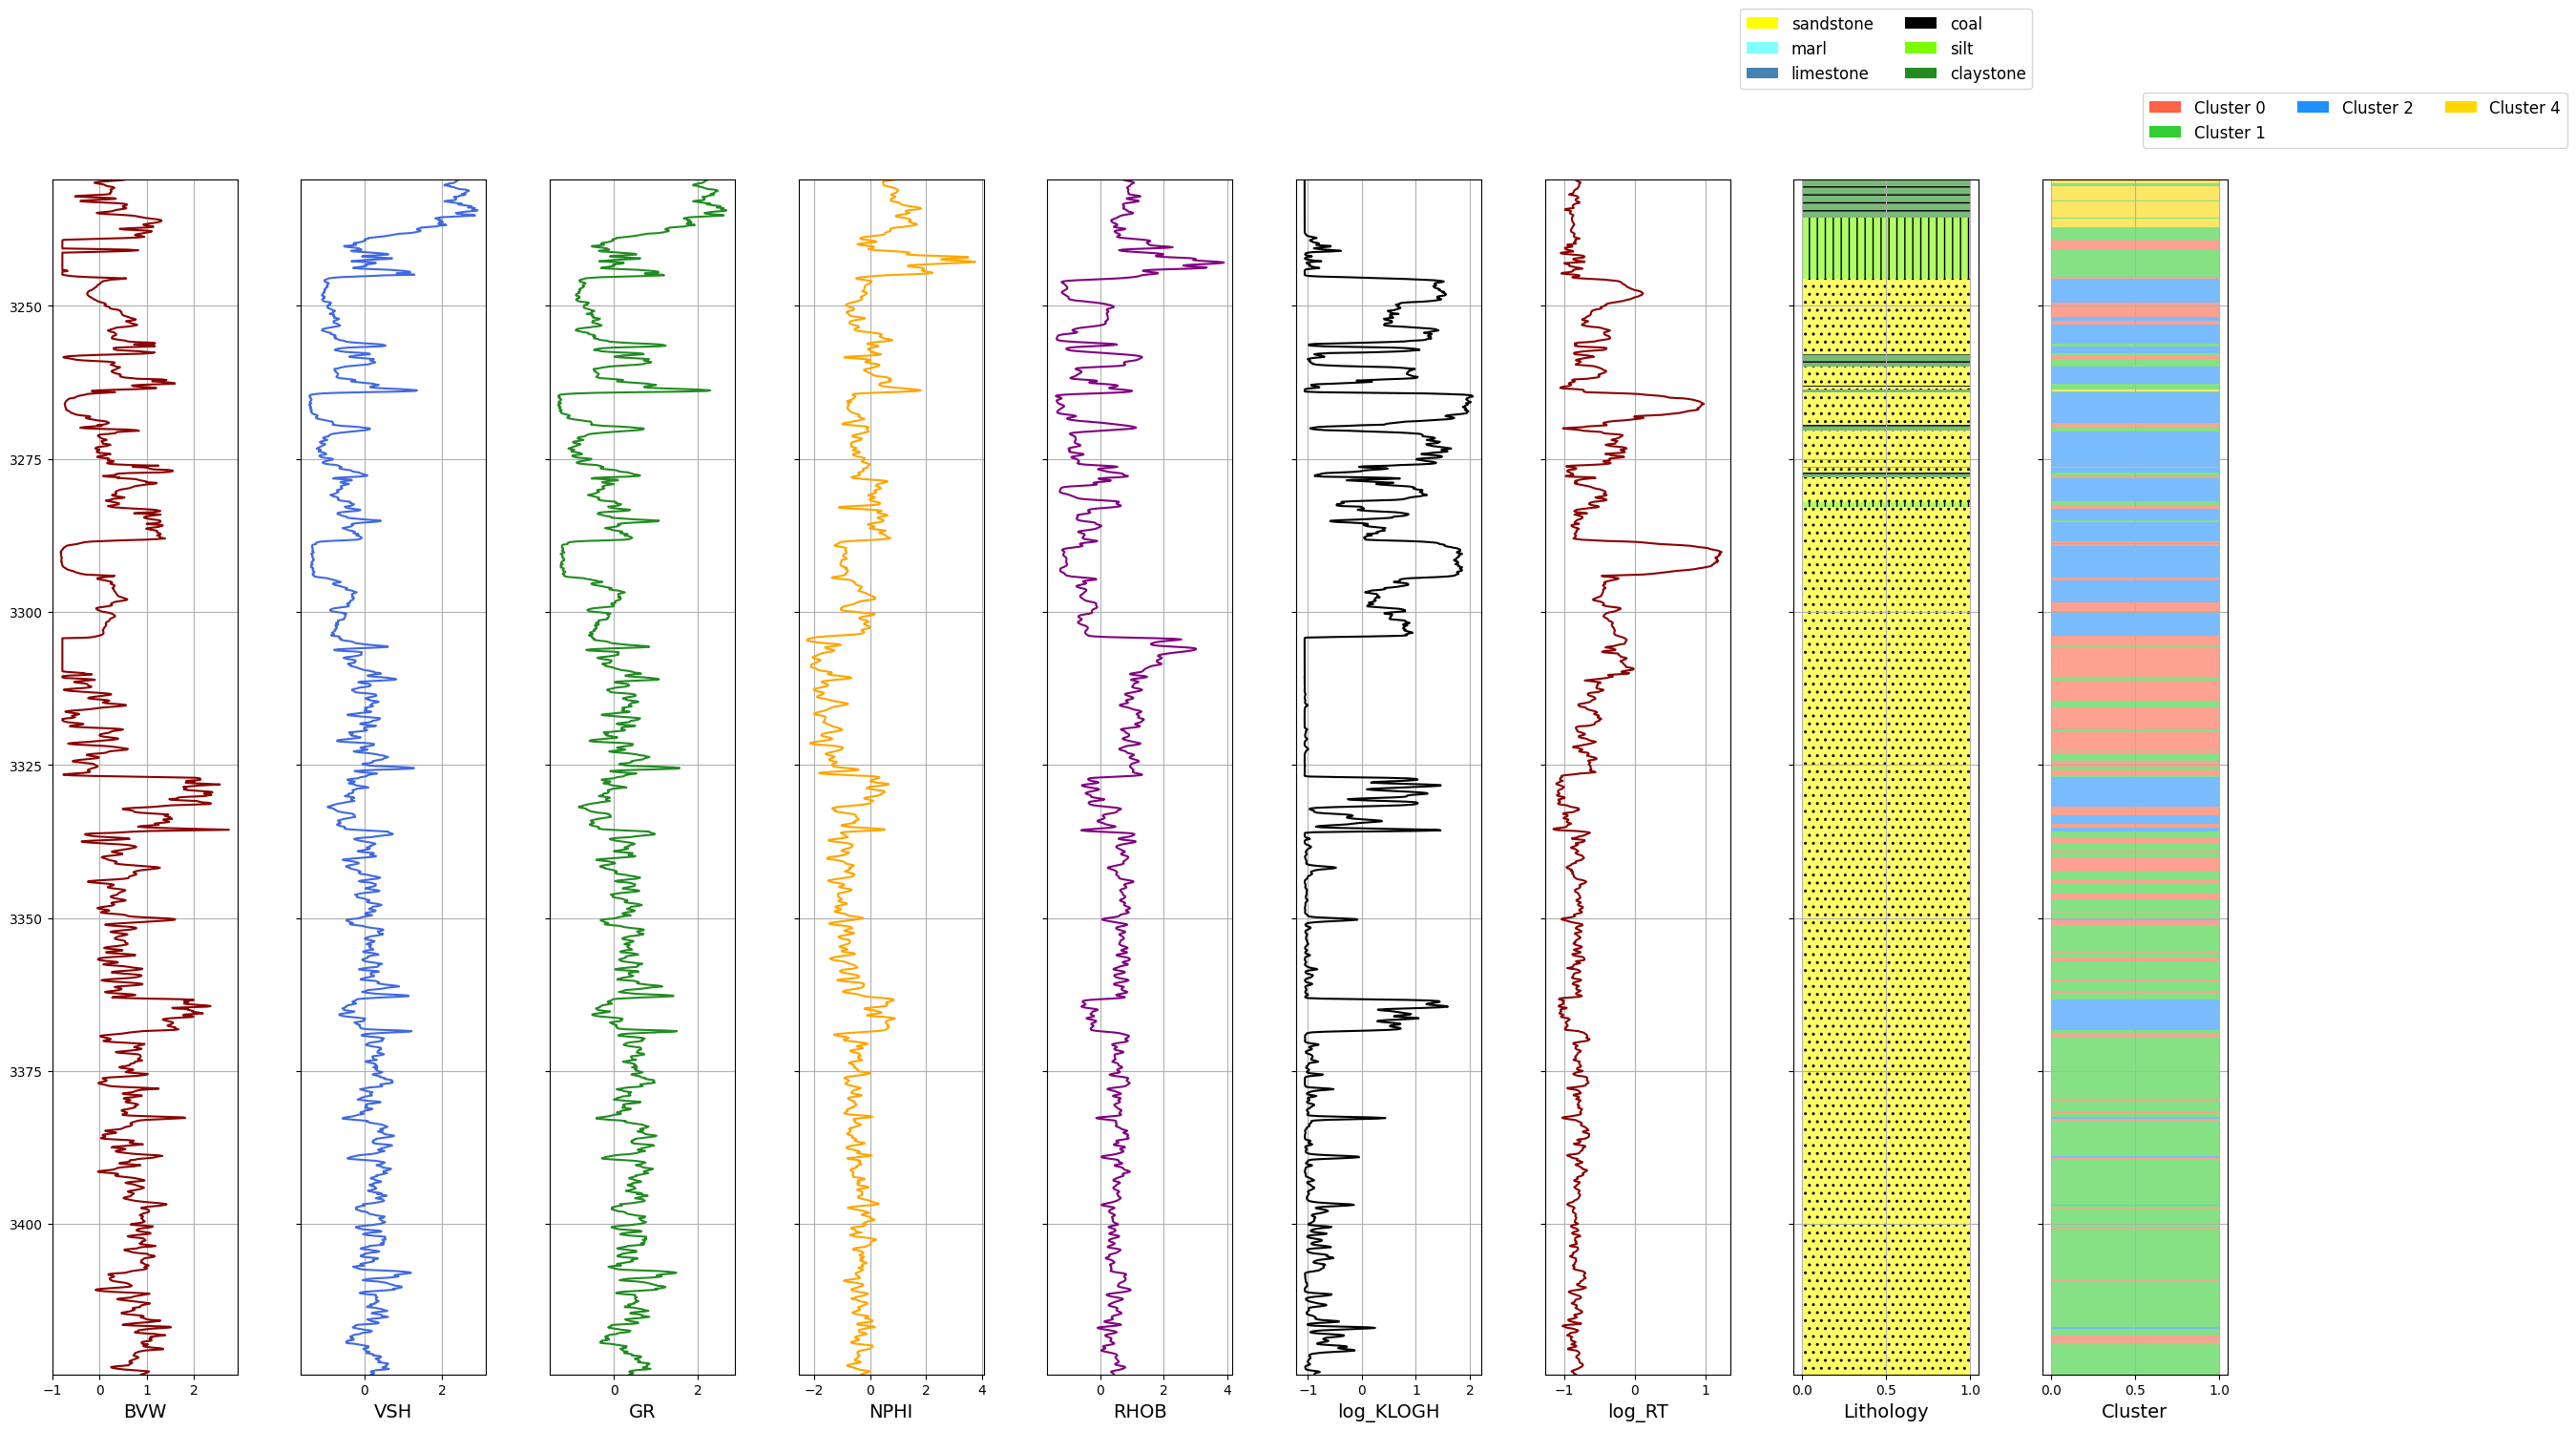

In [ ]:
KMeans_Clustering.visualise_lithology_clusters(train_clustered_2, log_columns=column_names)

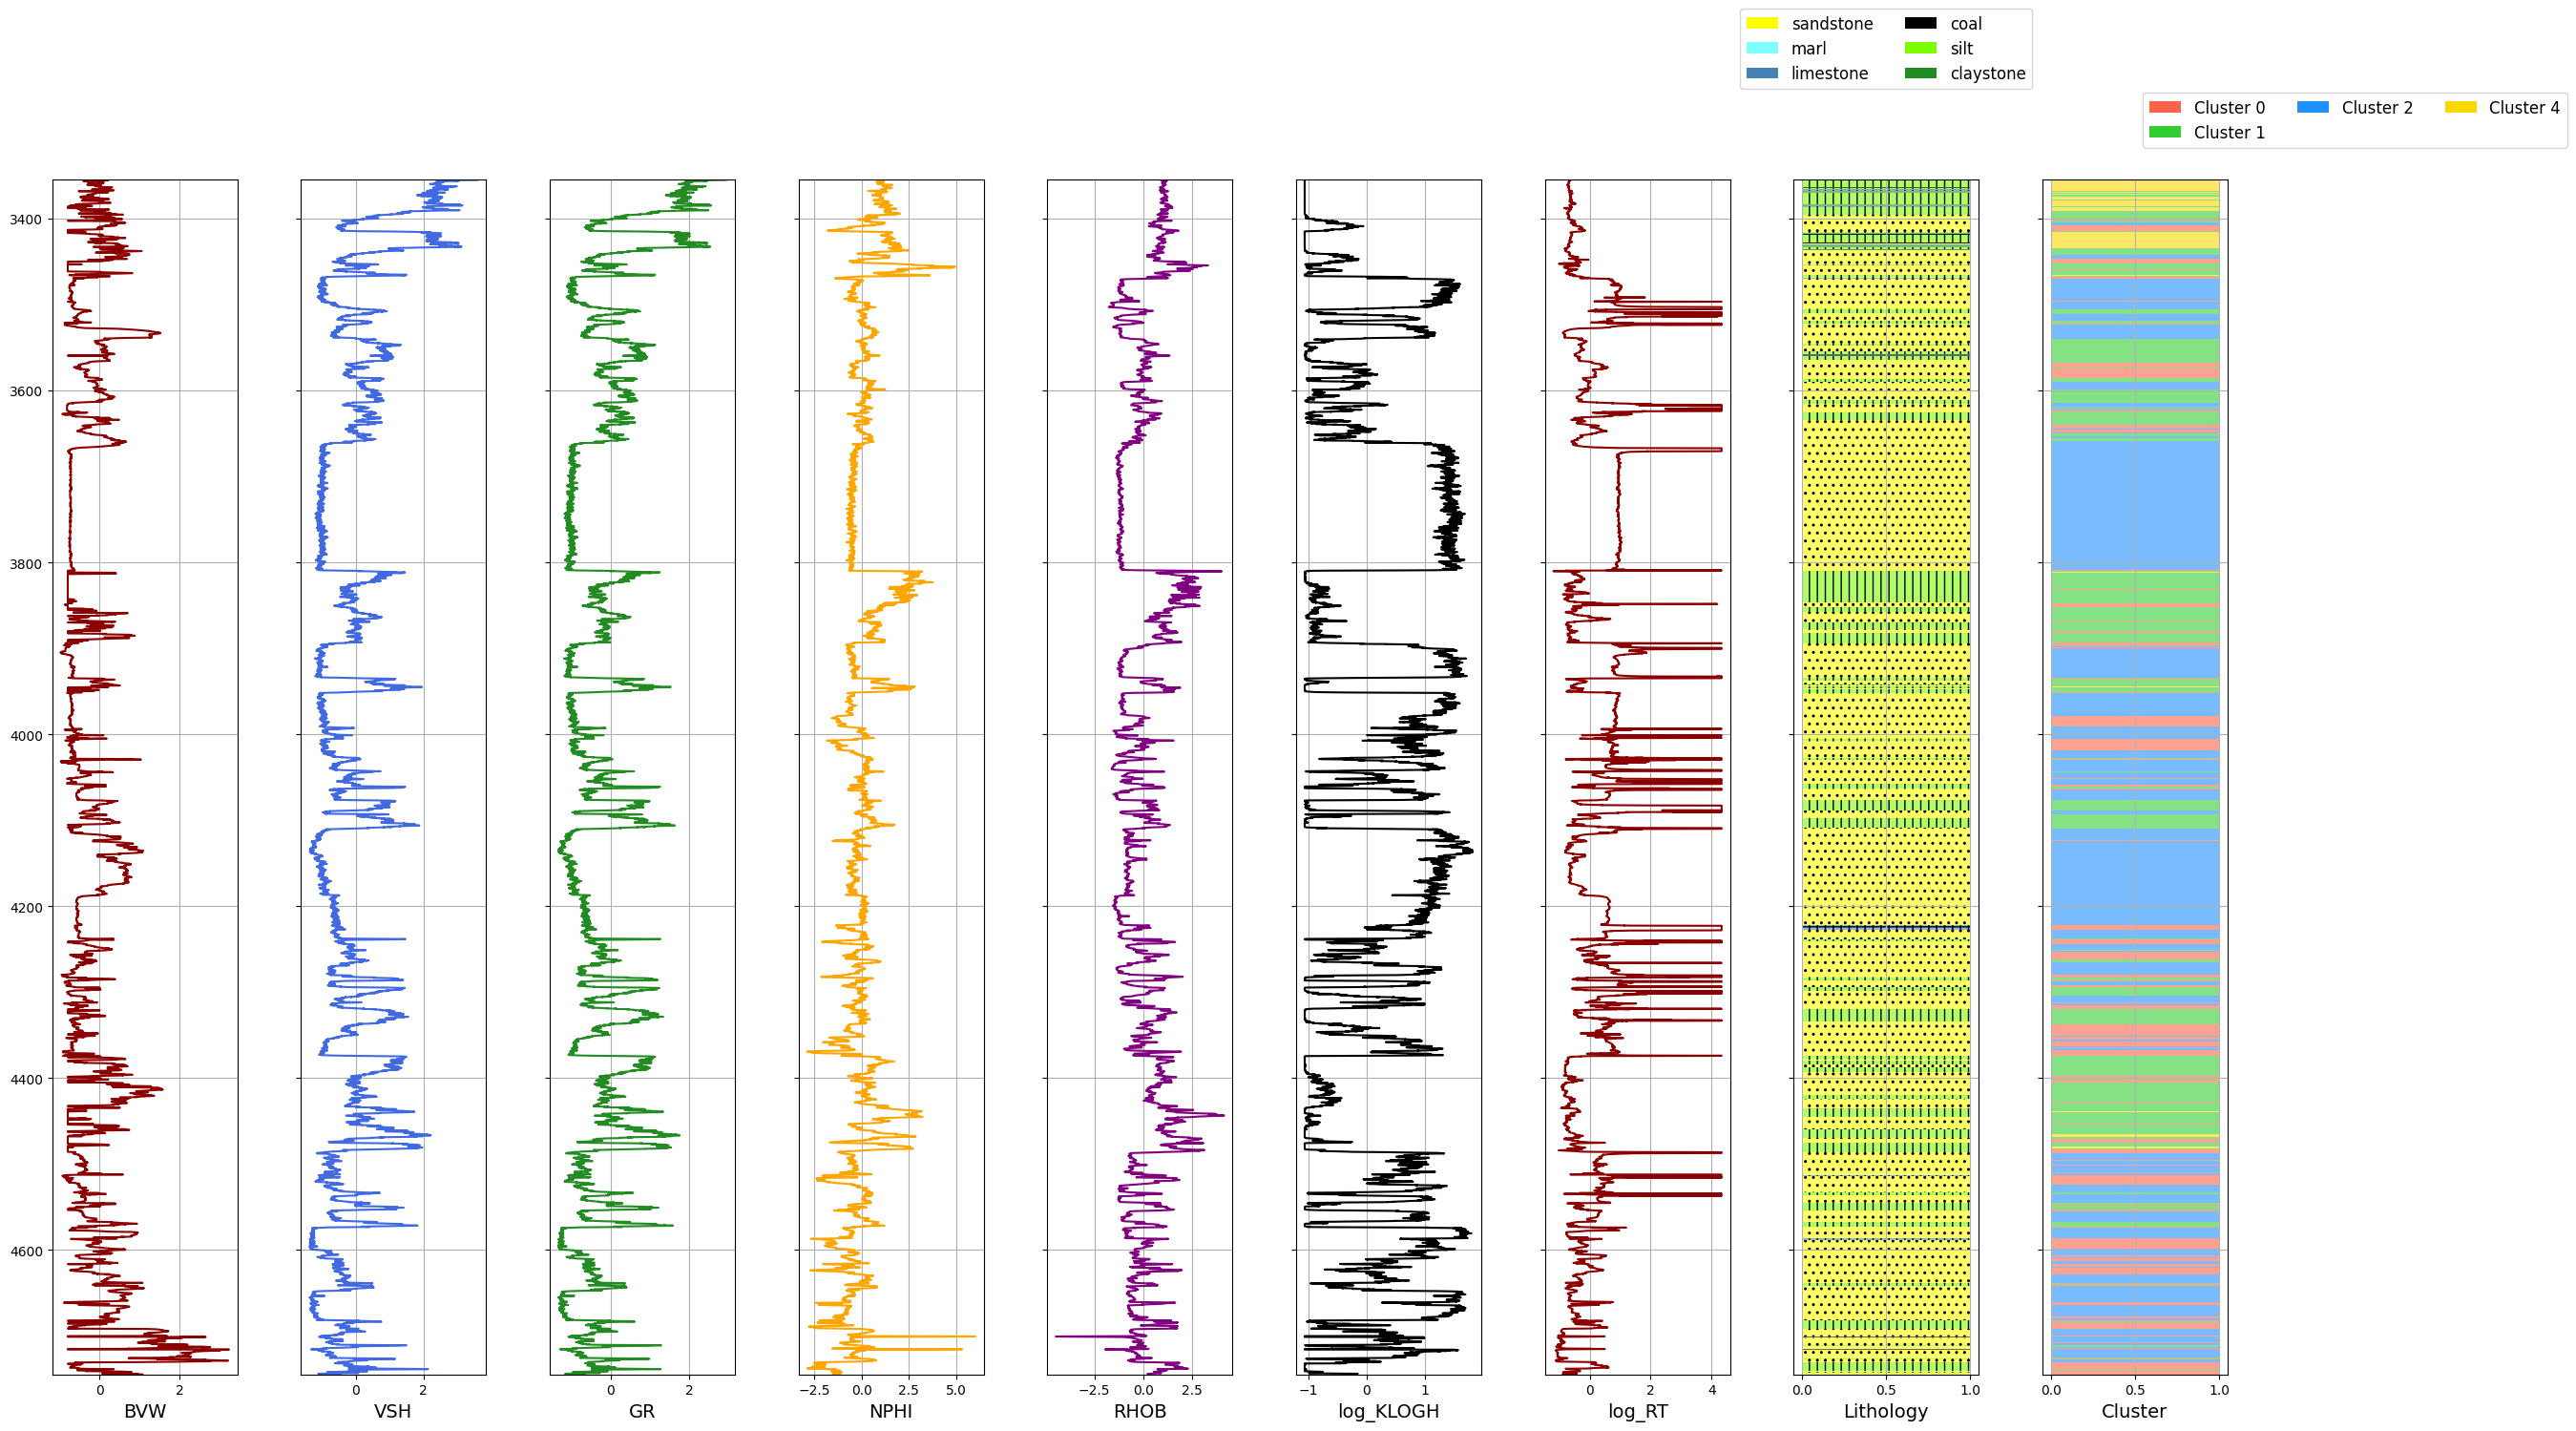

In [ ]:
KMeans_Clustering.visualise_lithology_clusters(train_clustered_3, log_columns=column_names)

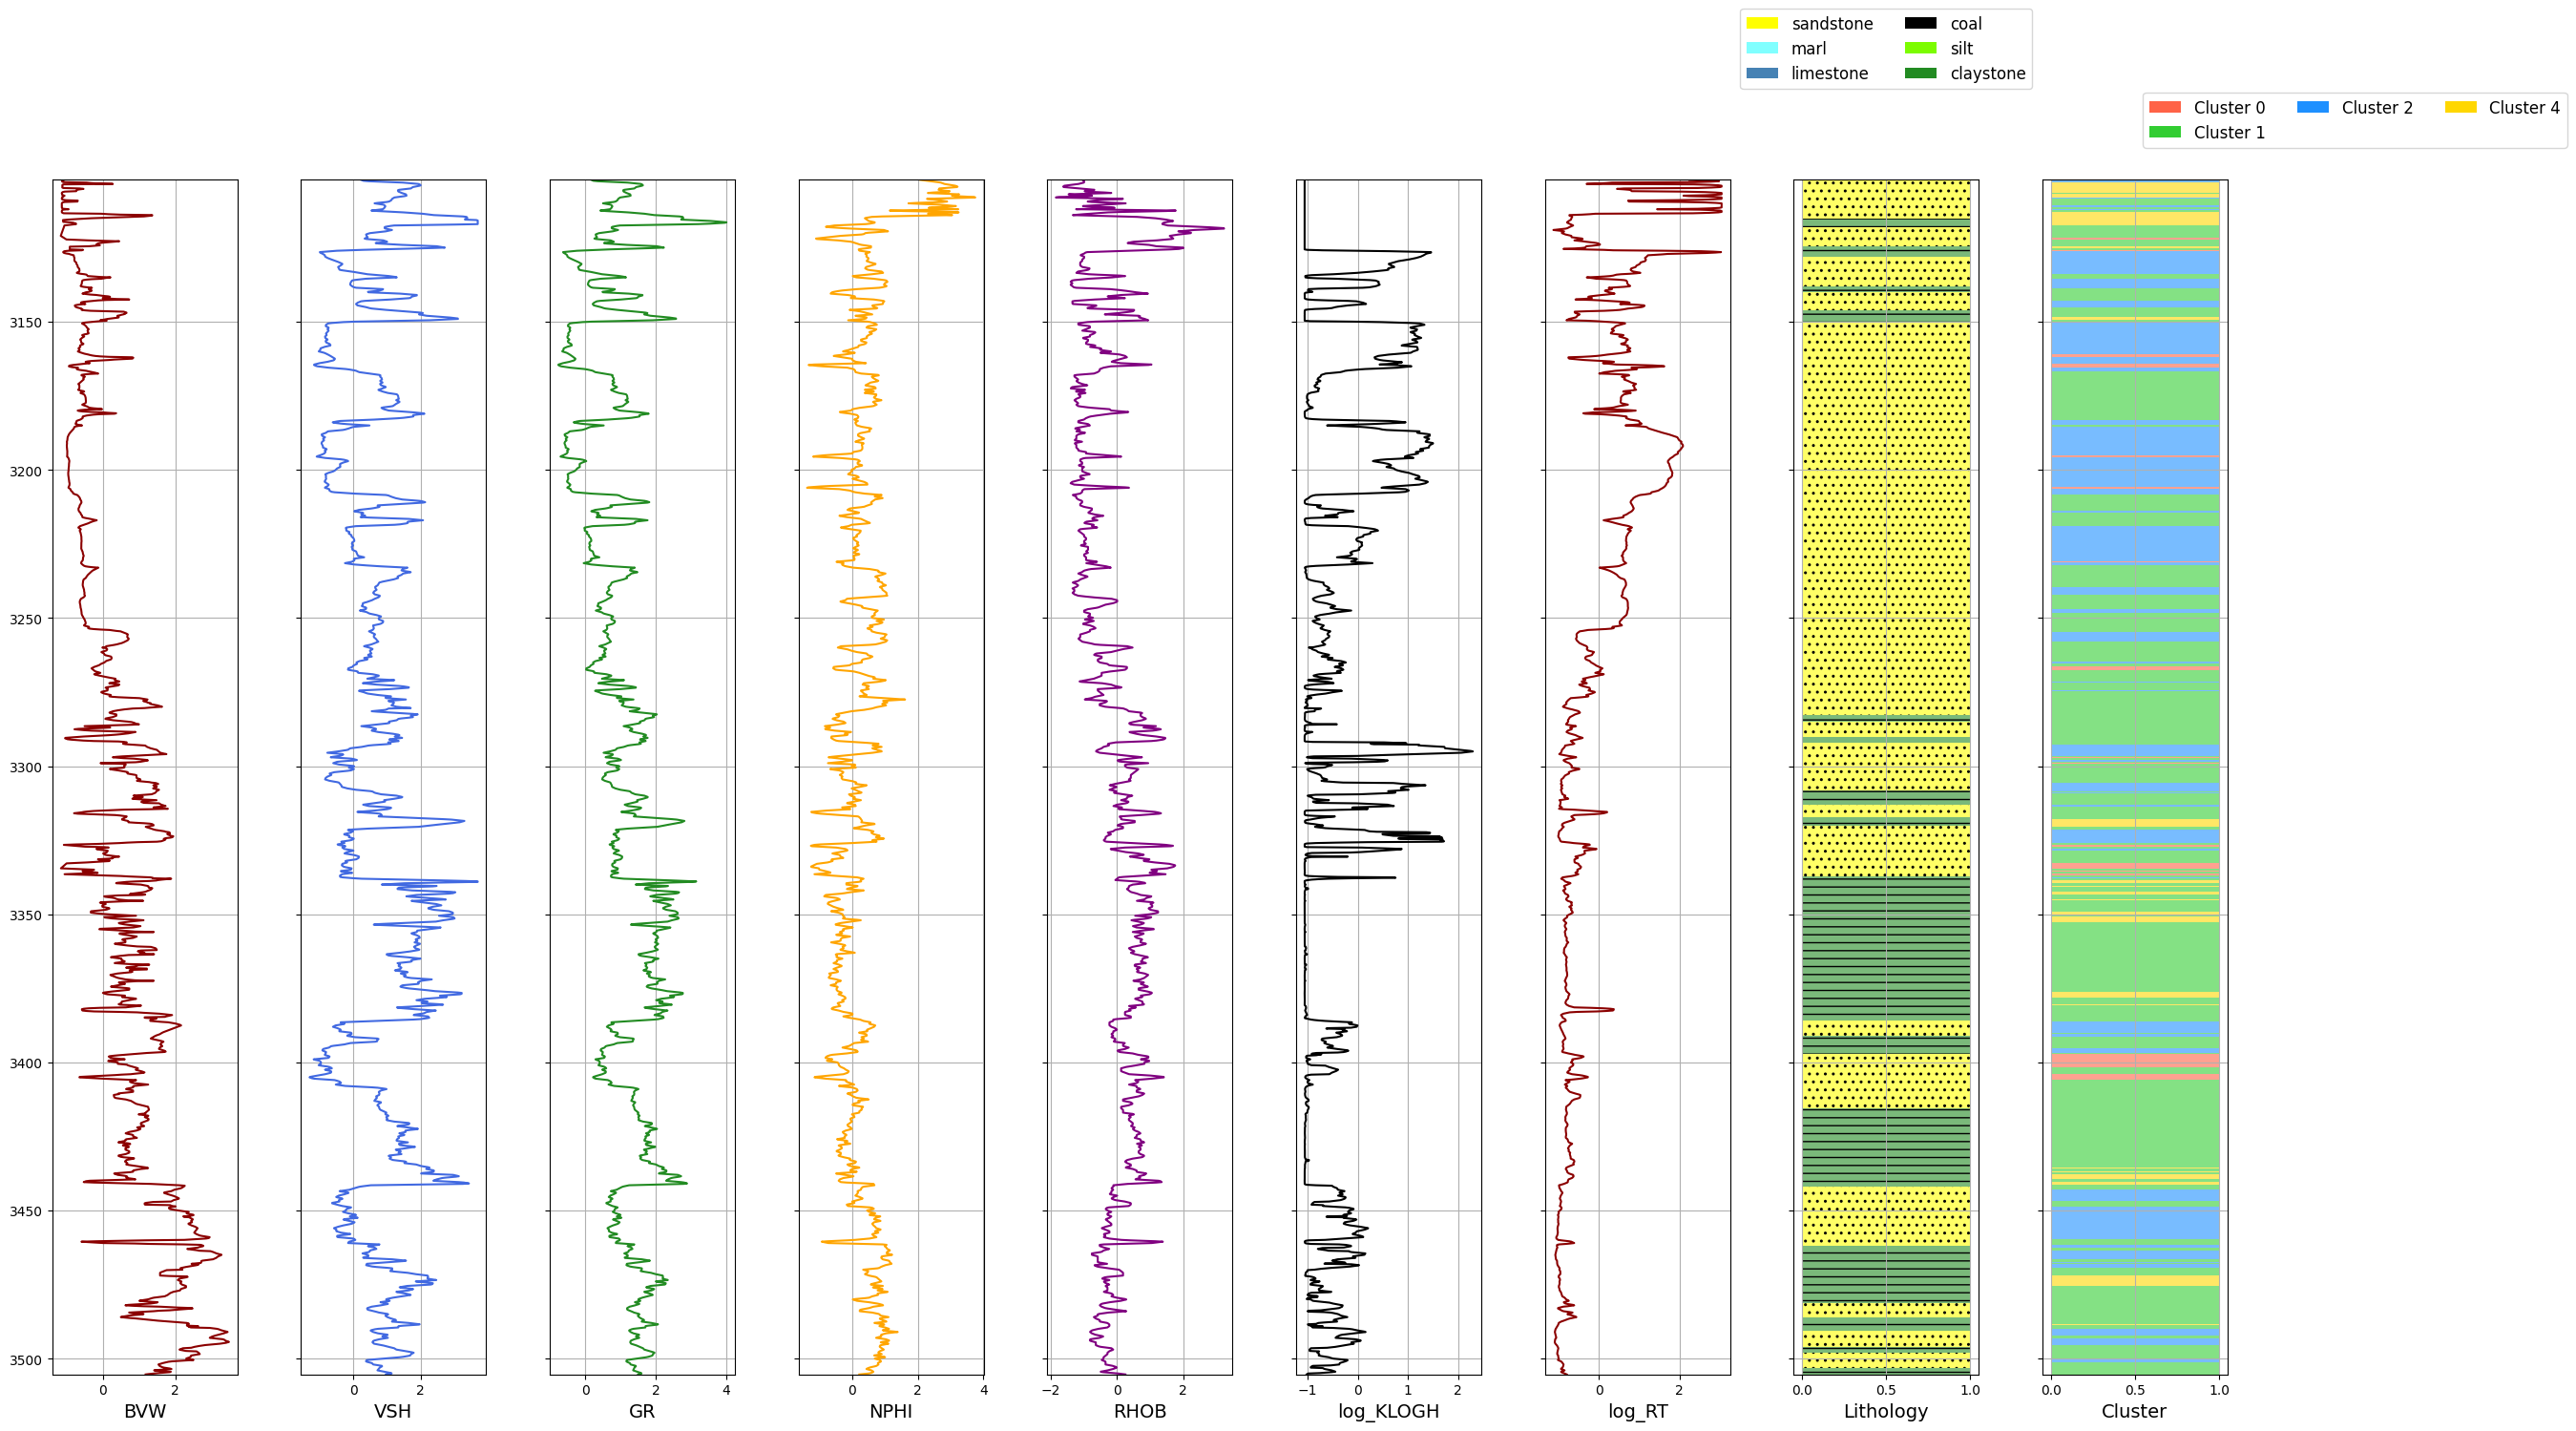

In [ ]:
KMeans_Clustering.visualise_lithology_clusters(train_clustered_4, log_columns=column_names)

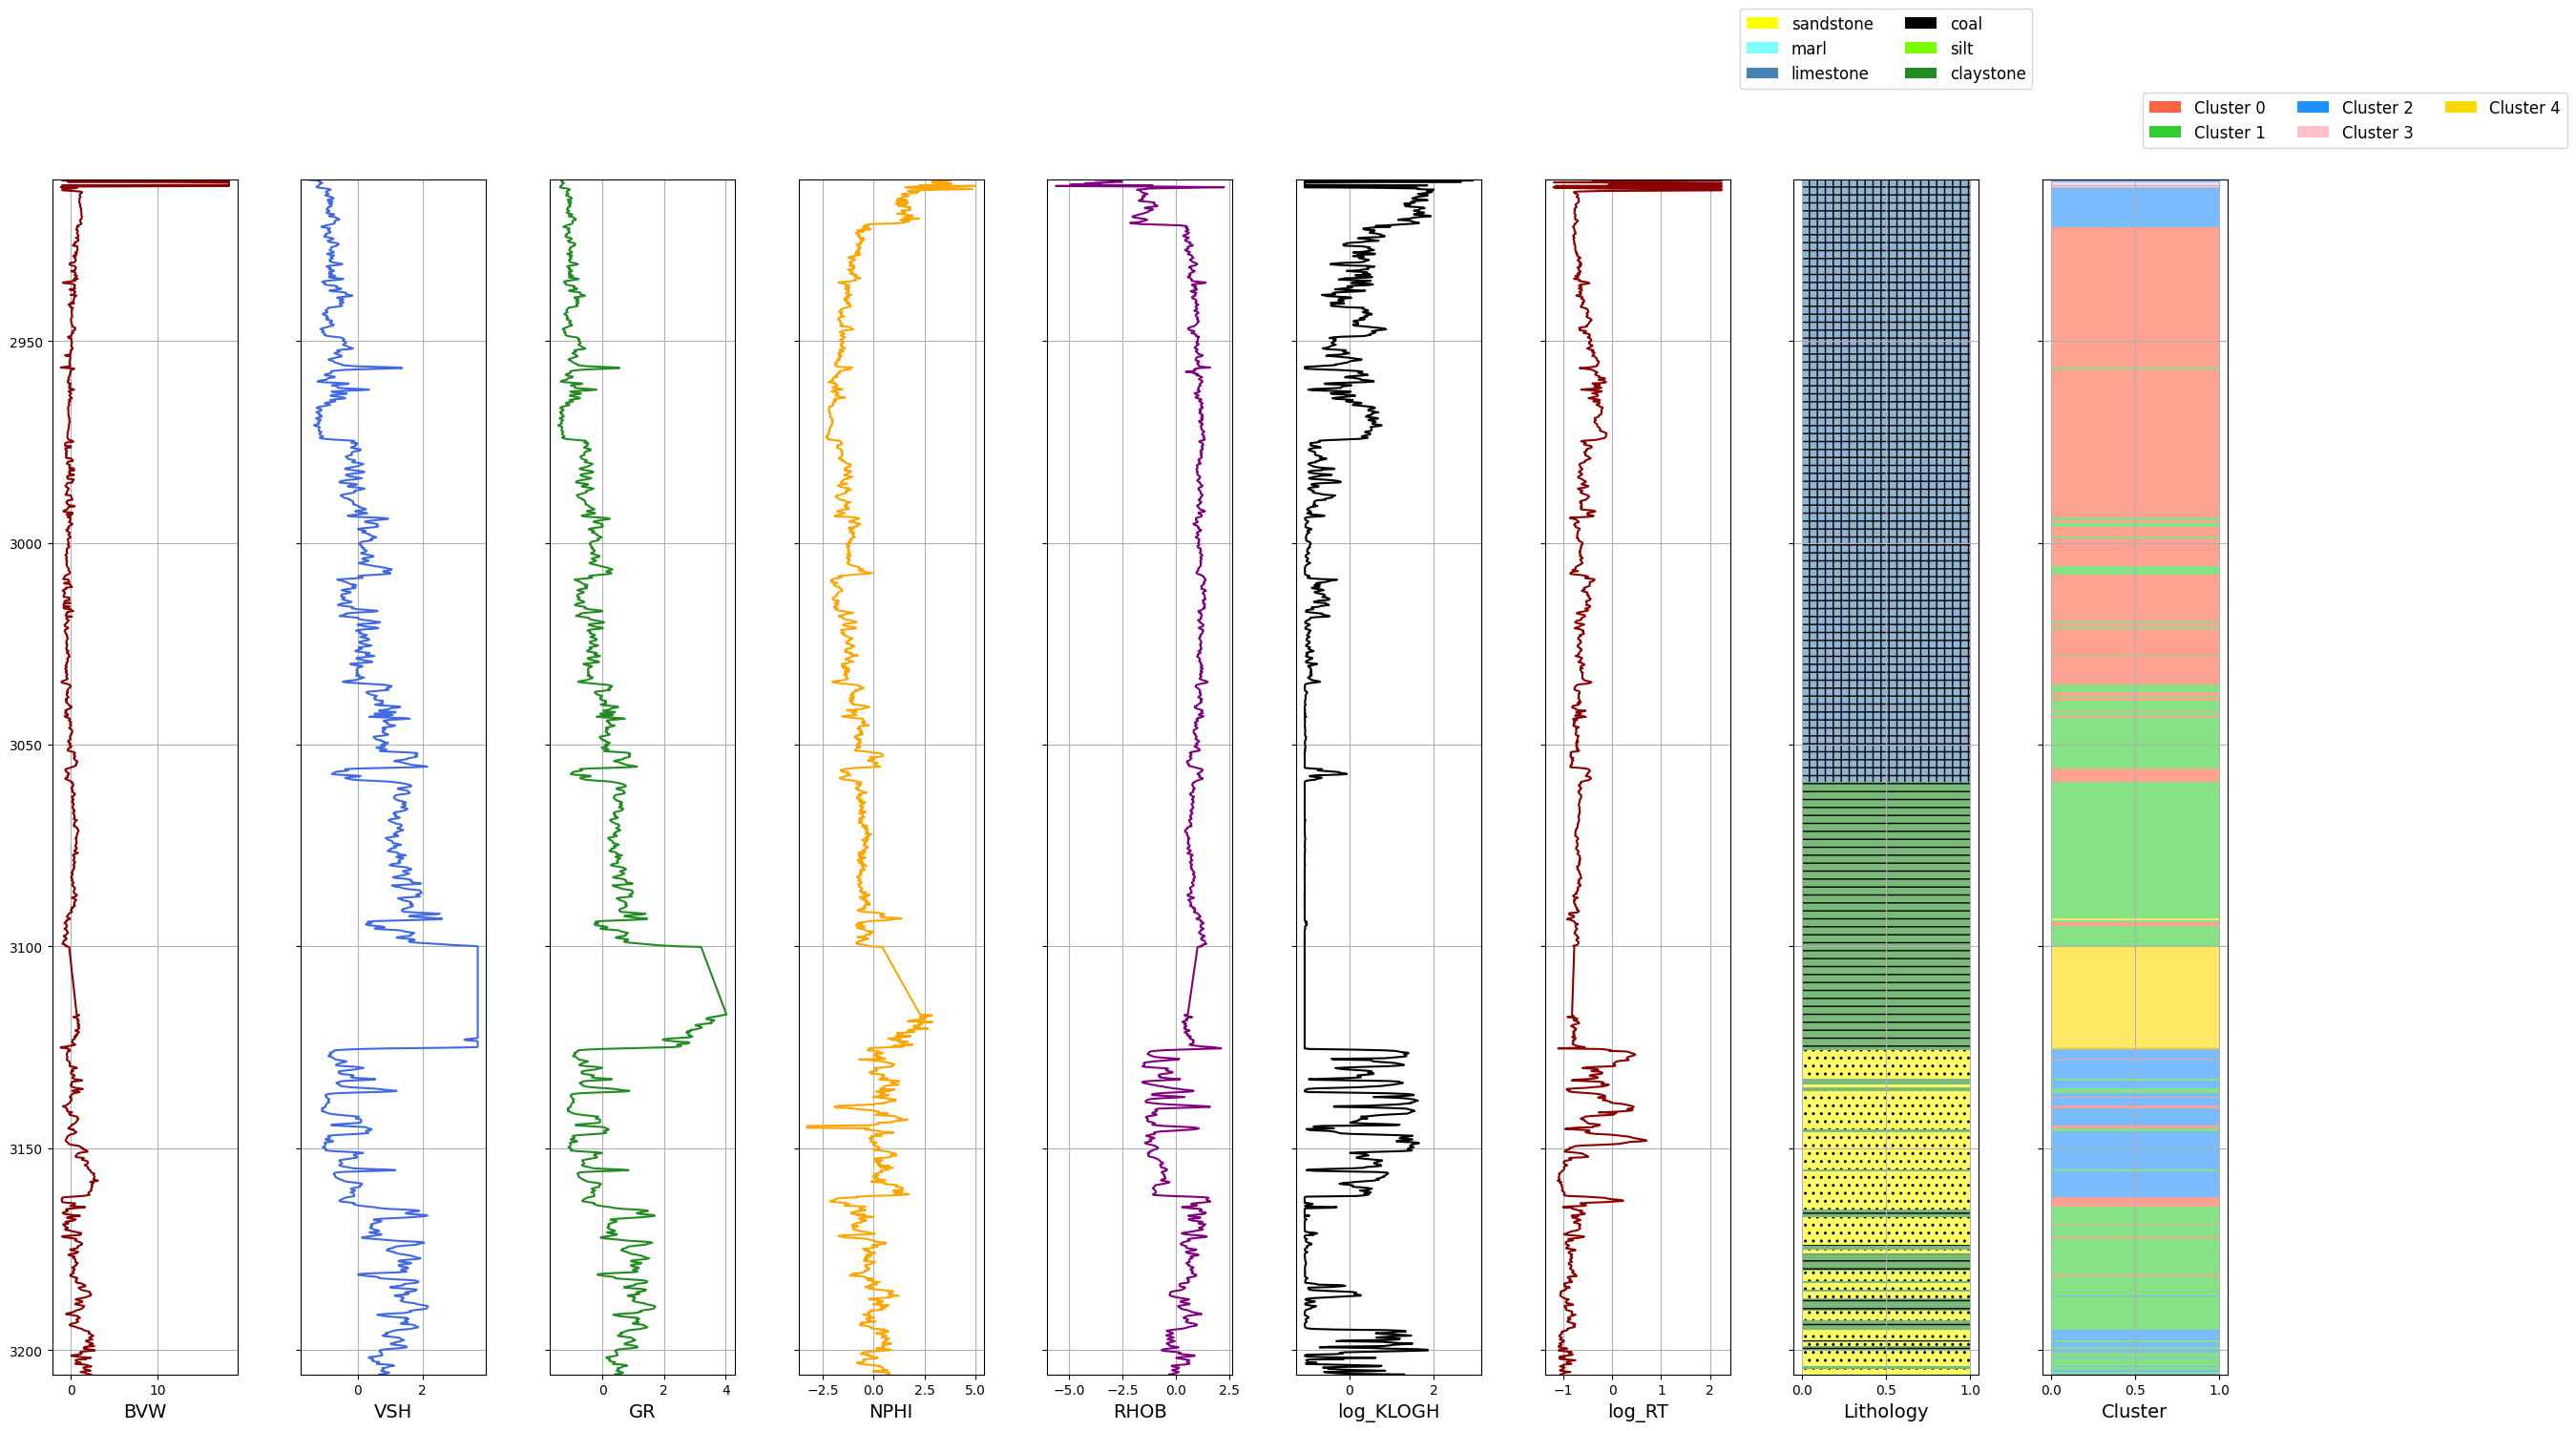

In [ ]:

KMeans_Clustering.visualise_lithology_clusters(train_clustered_5, log_columns=column_names)

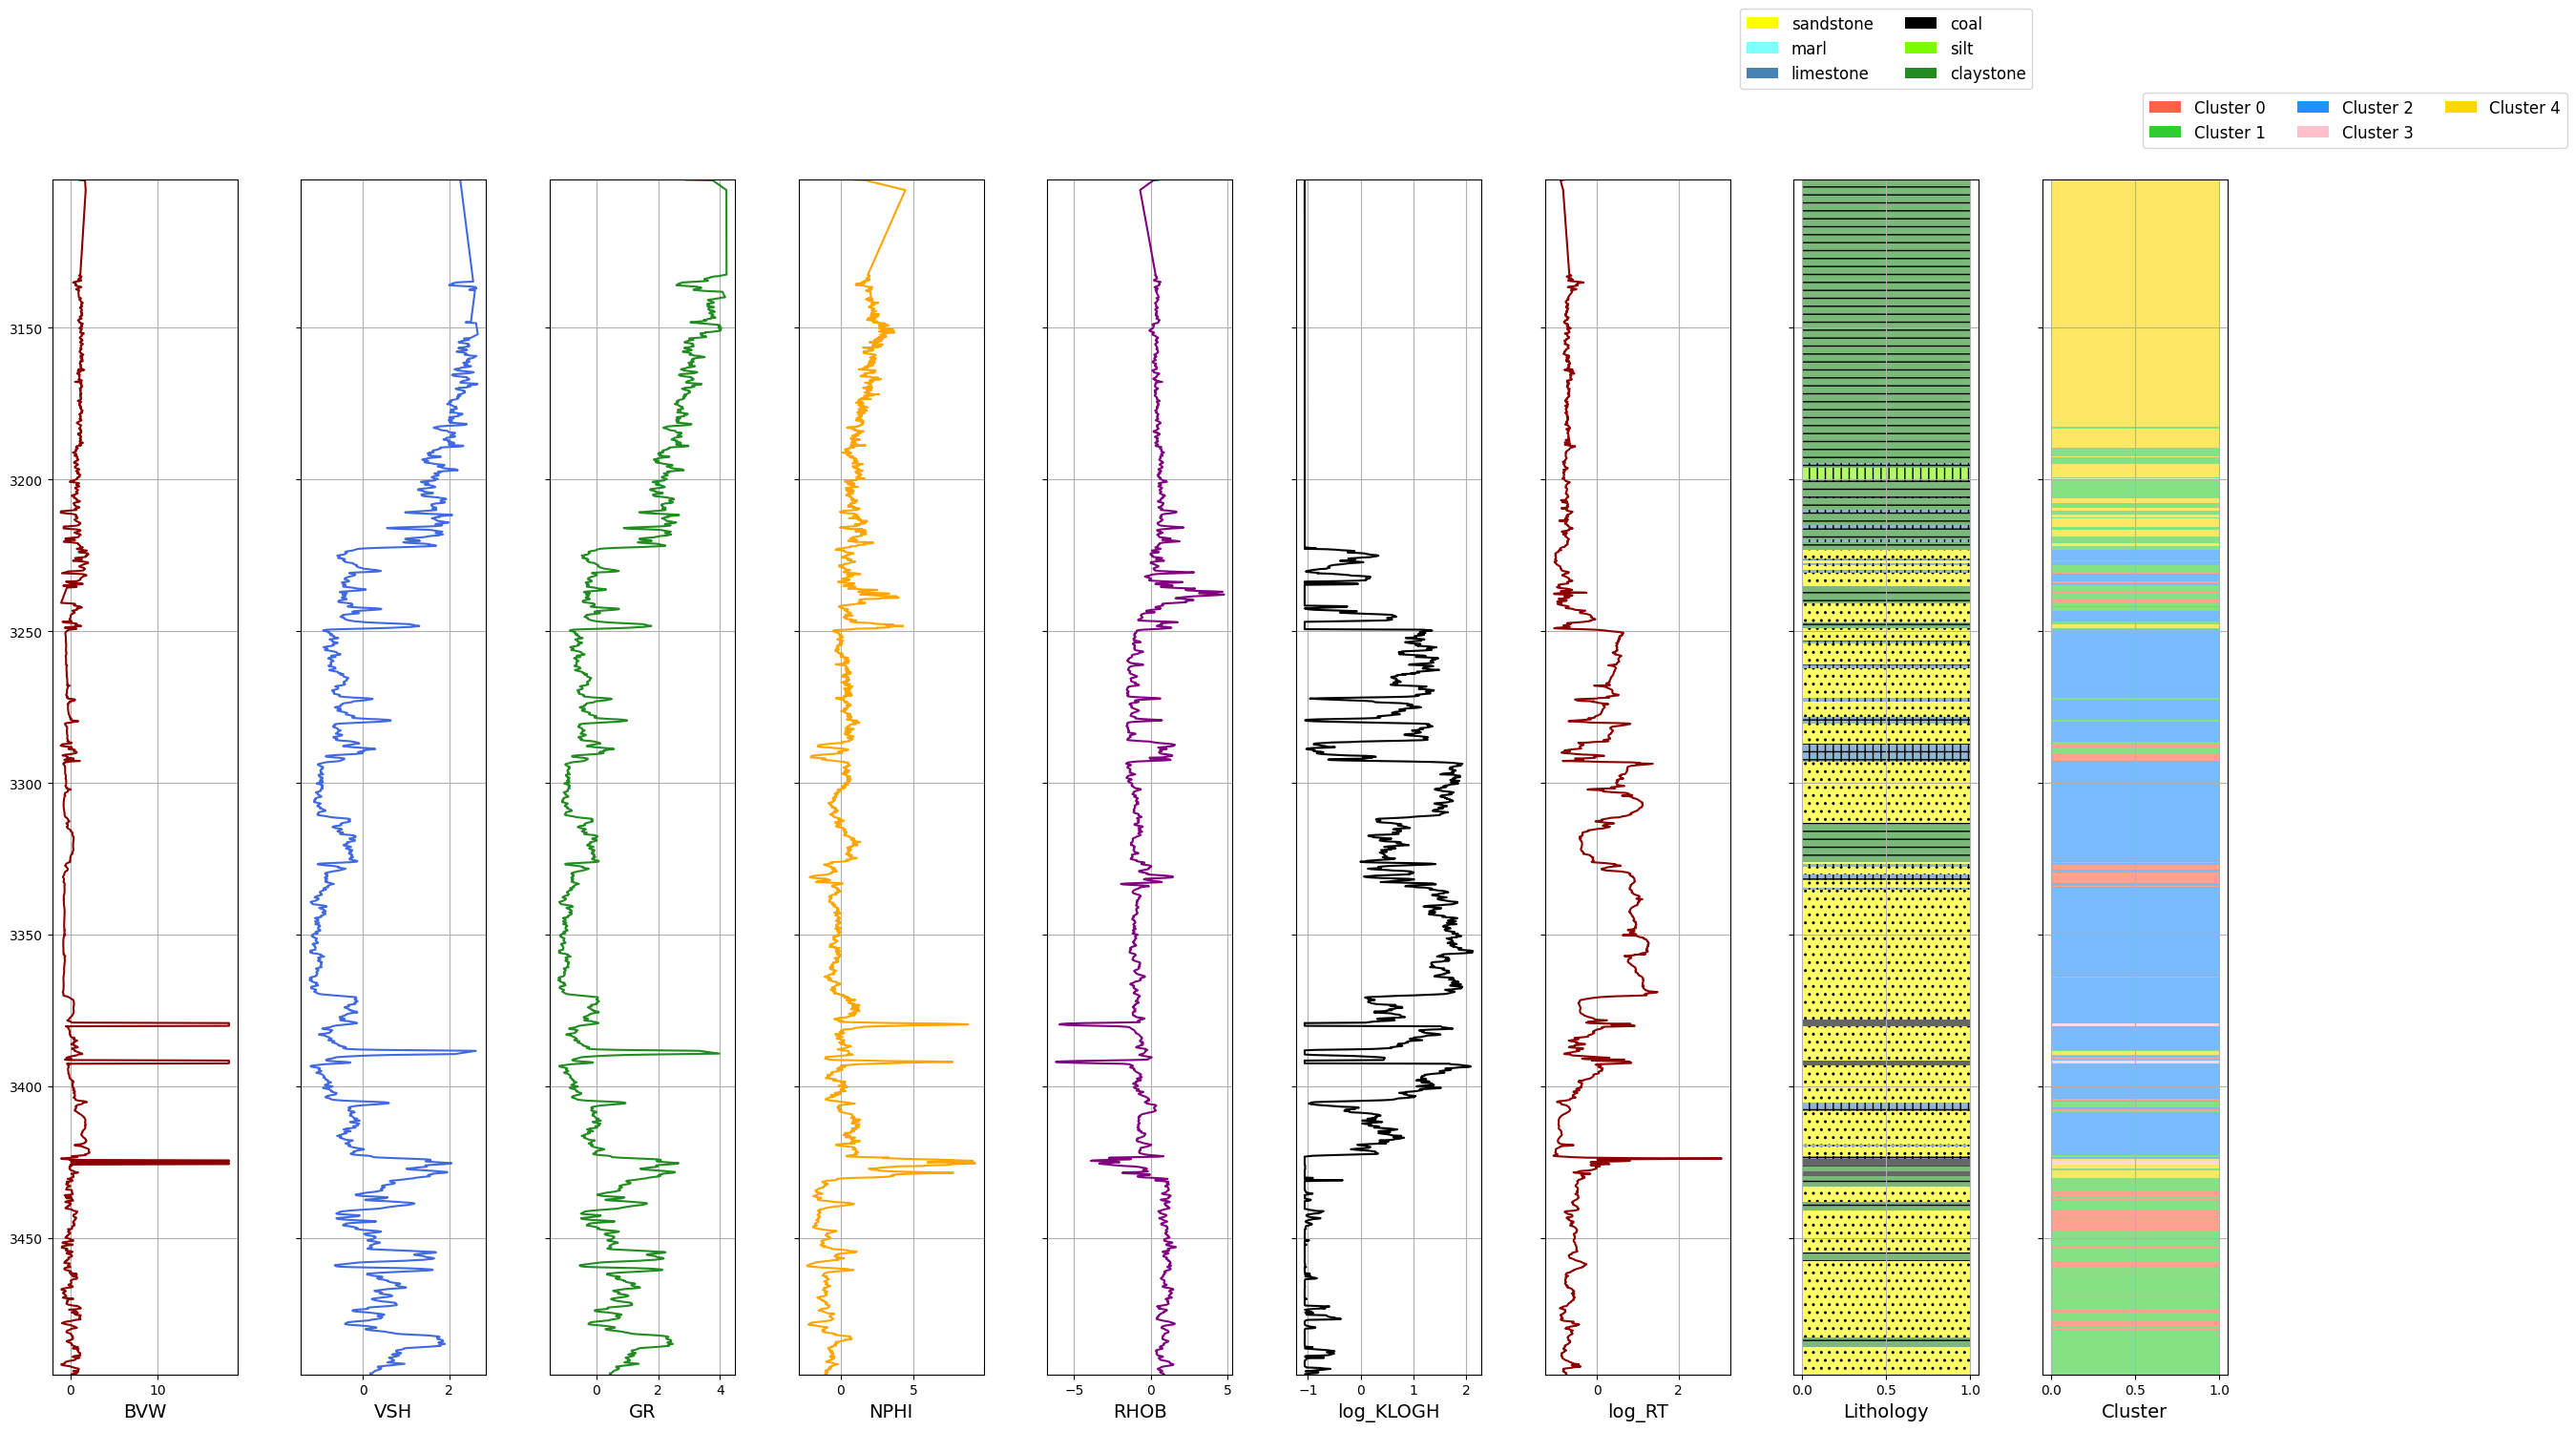

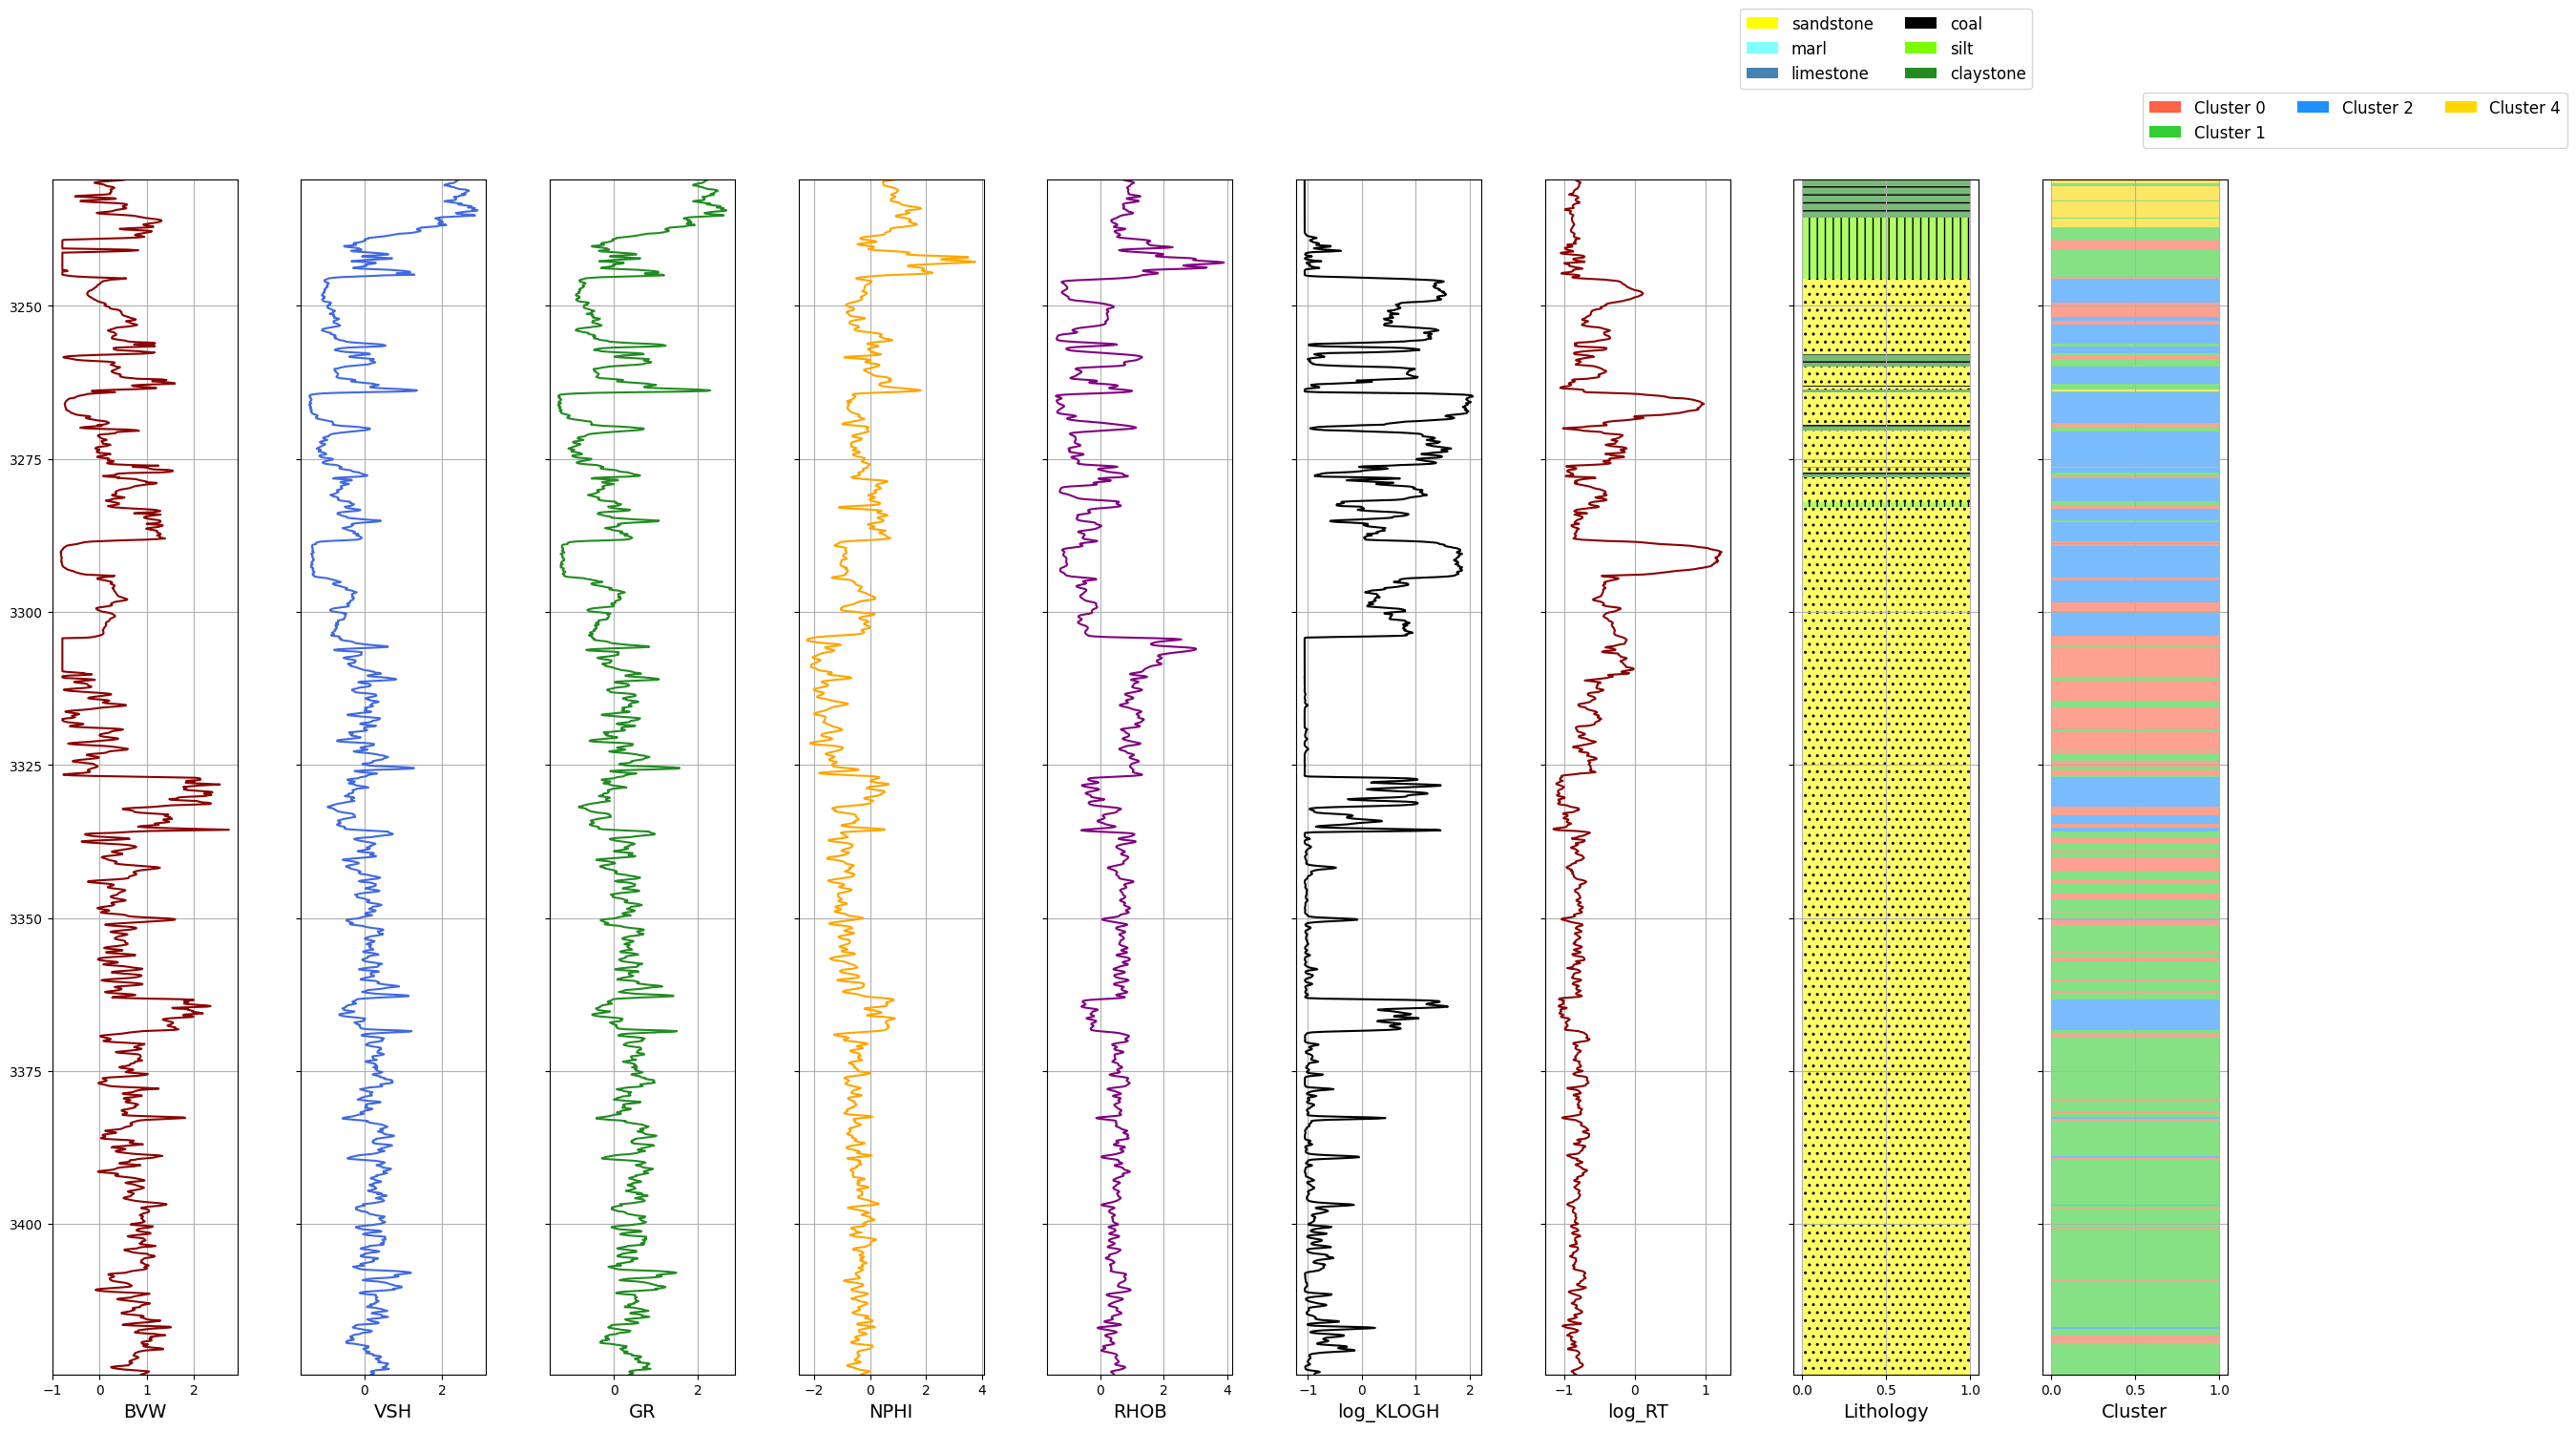

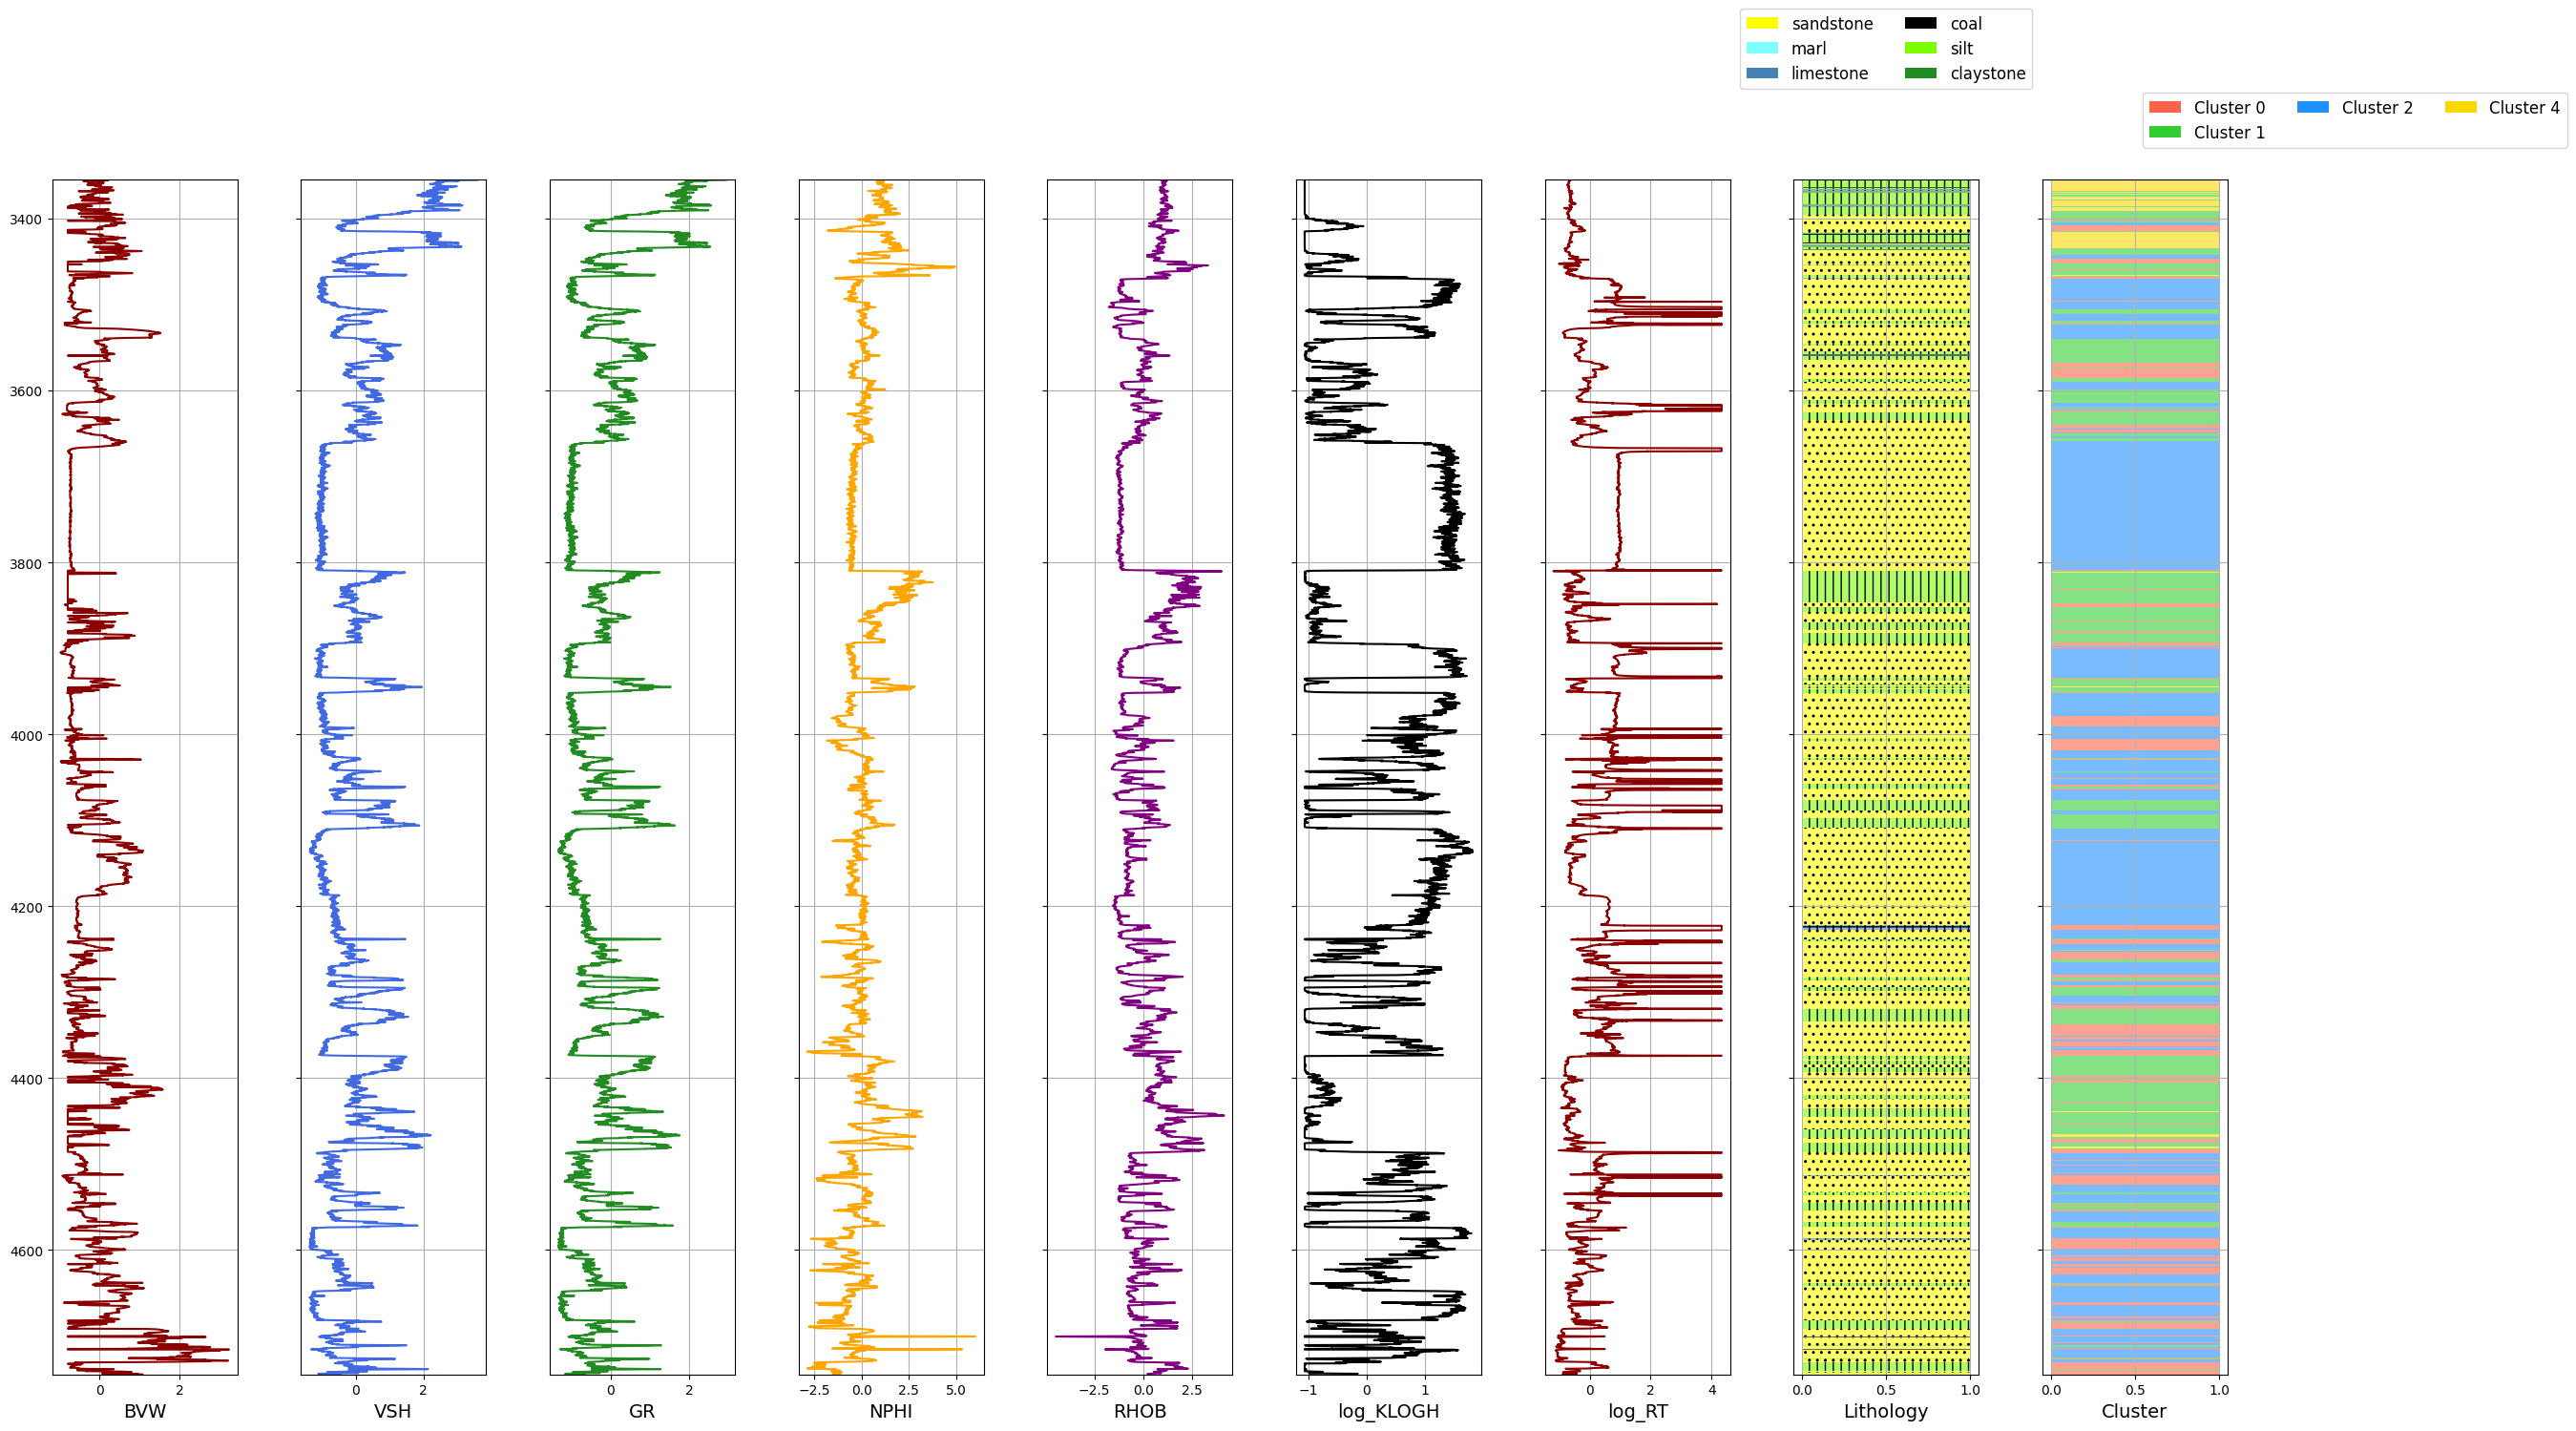

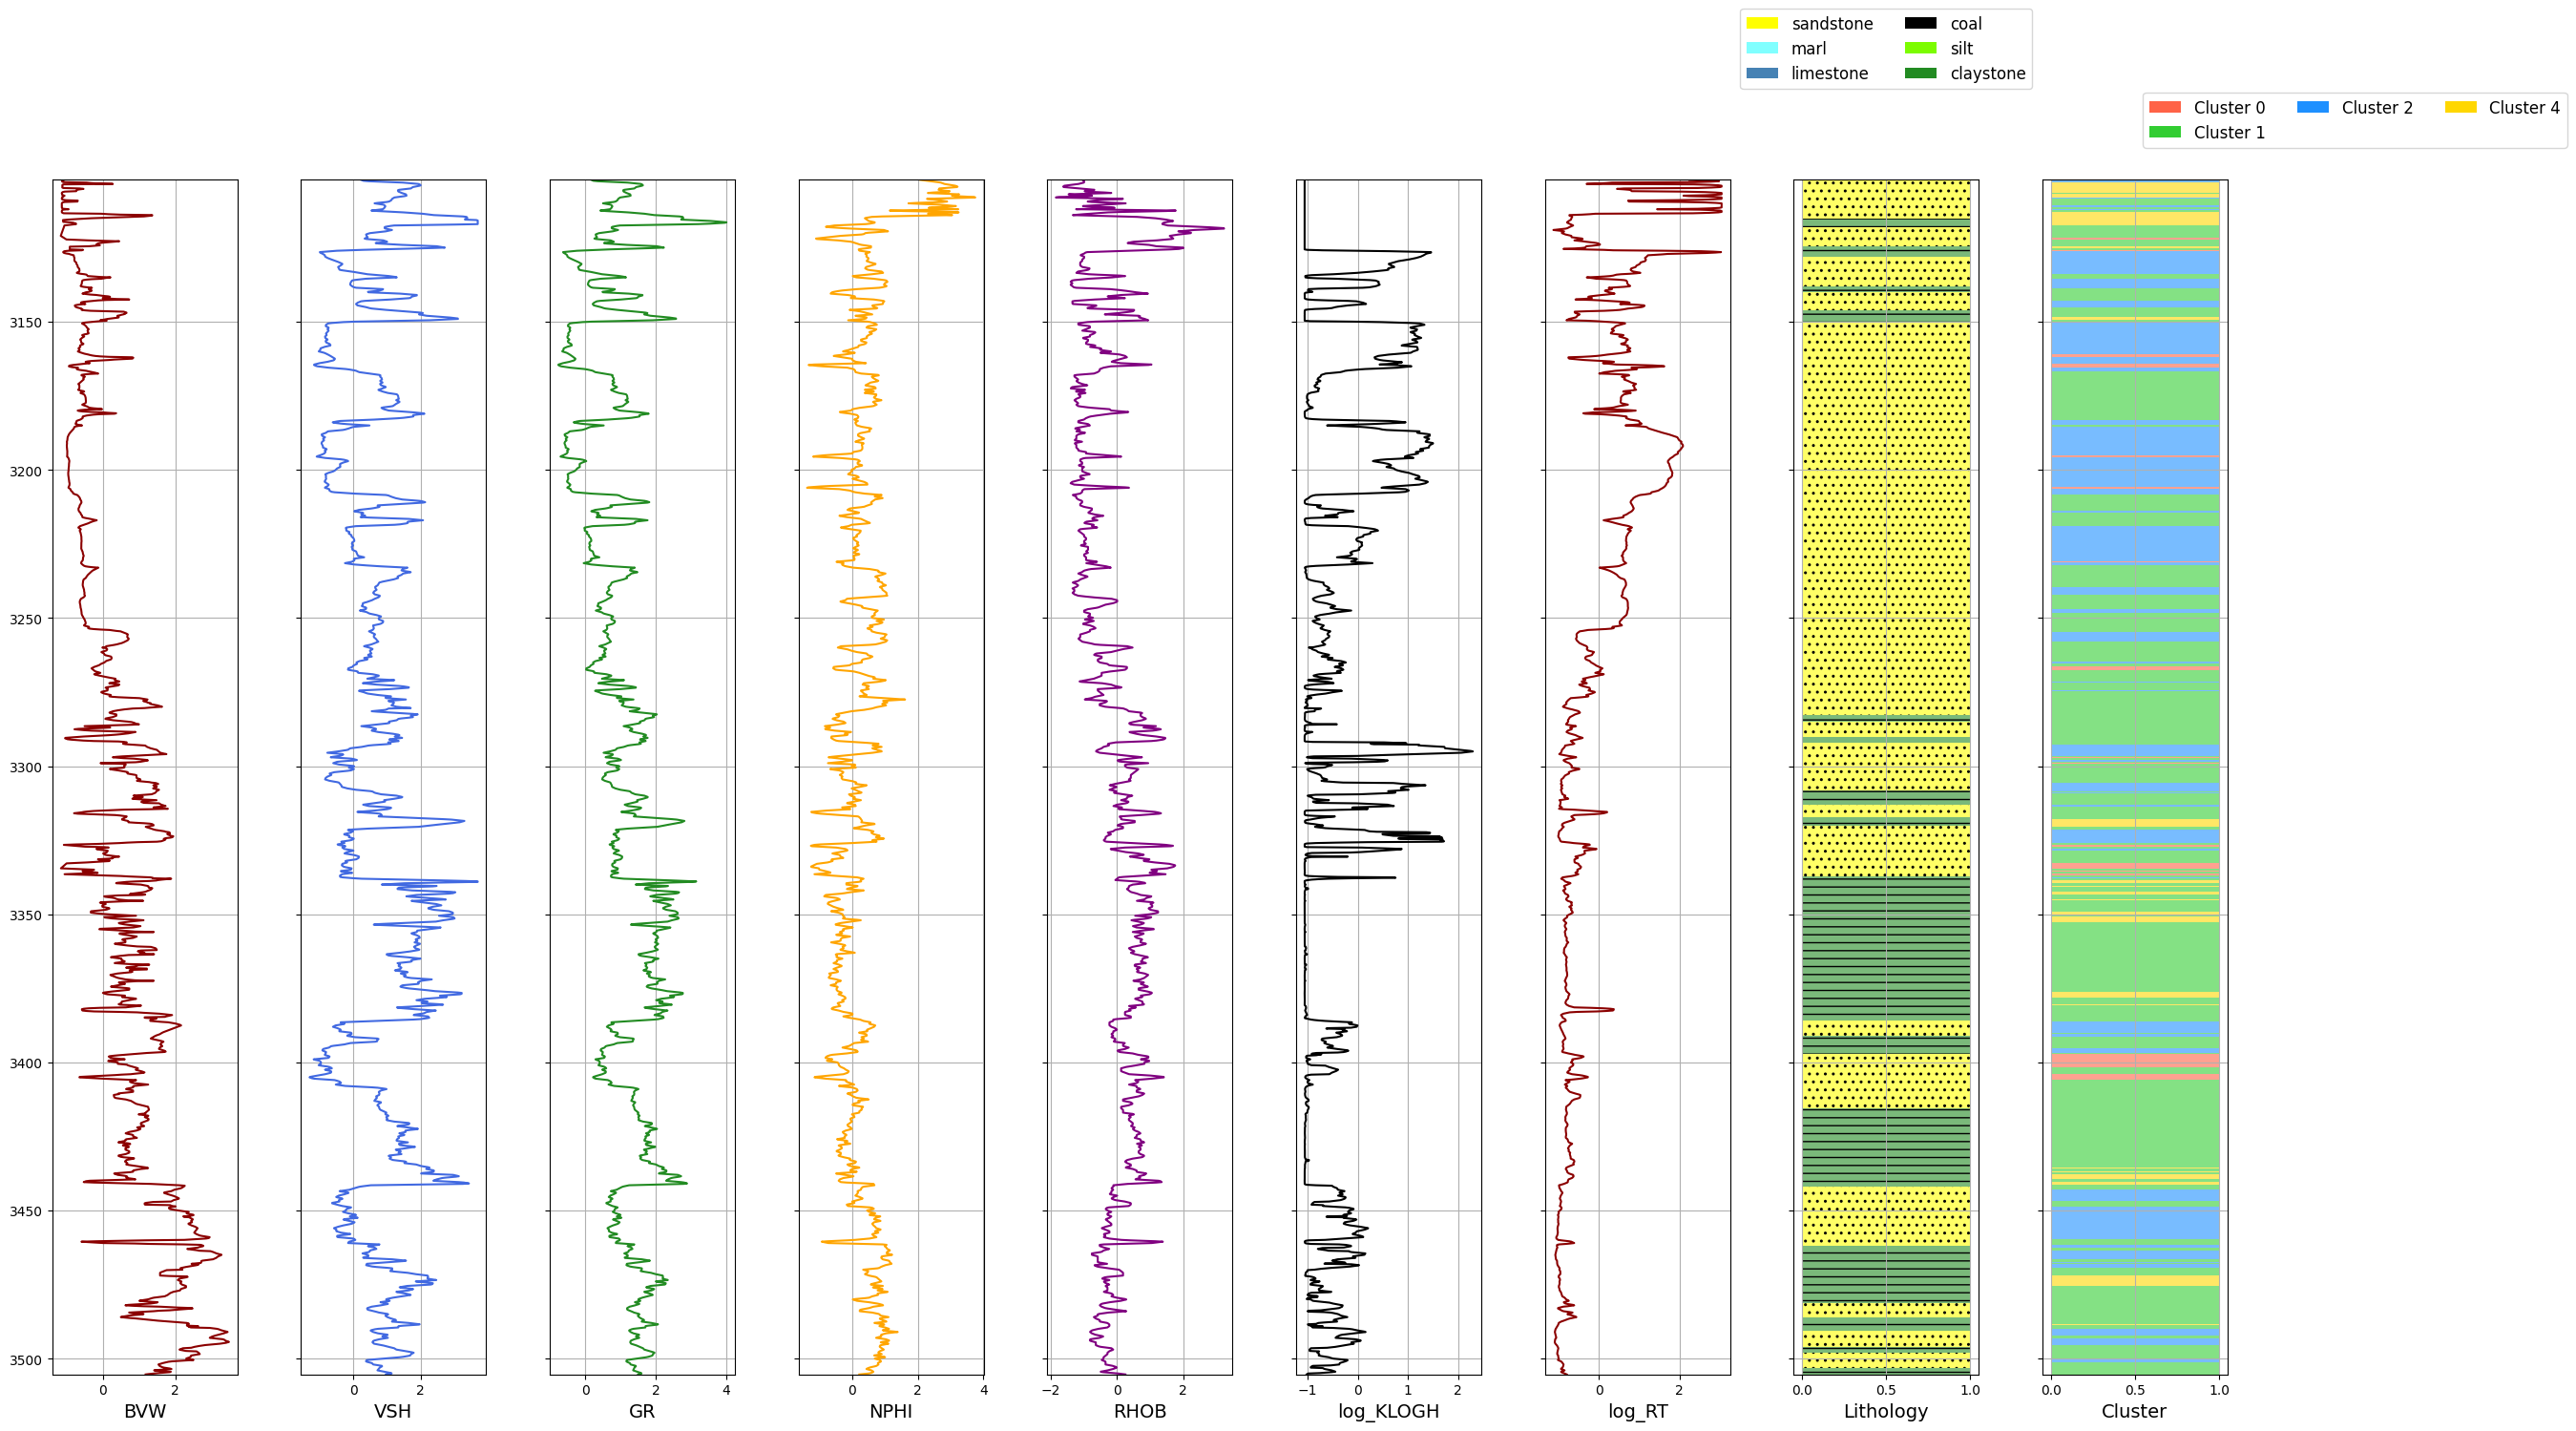

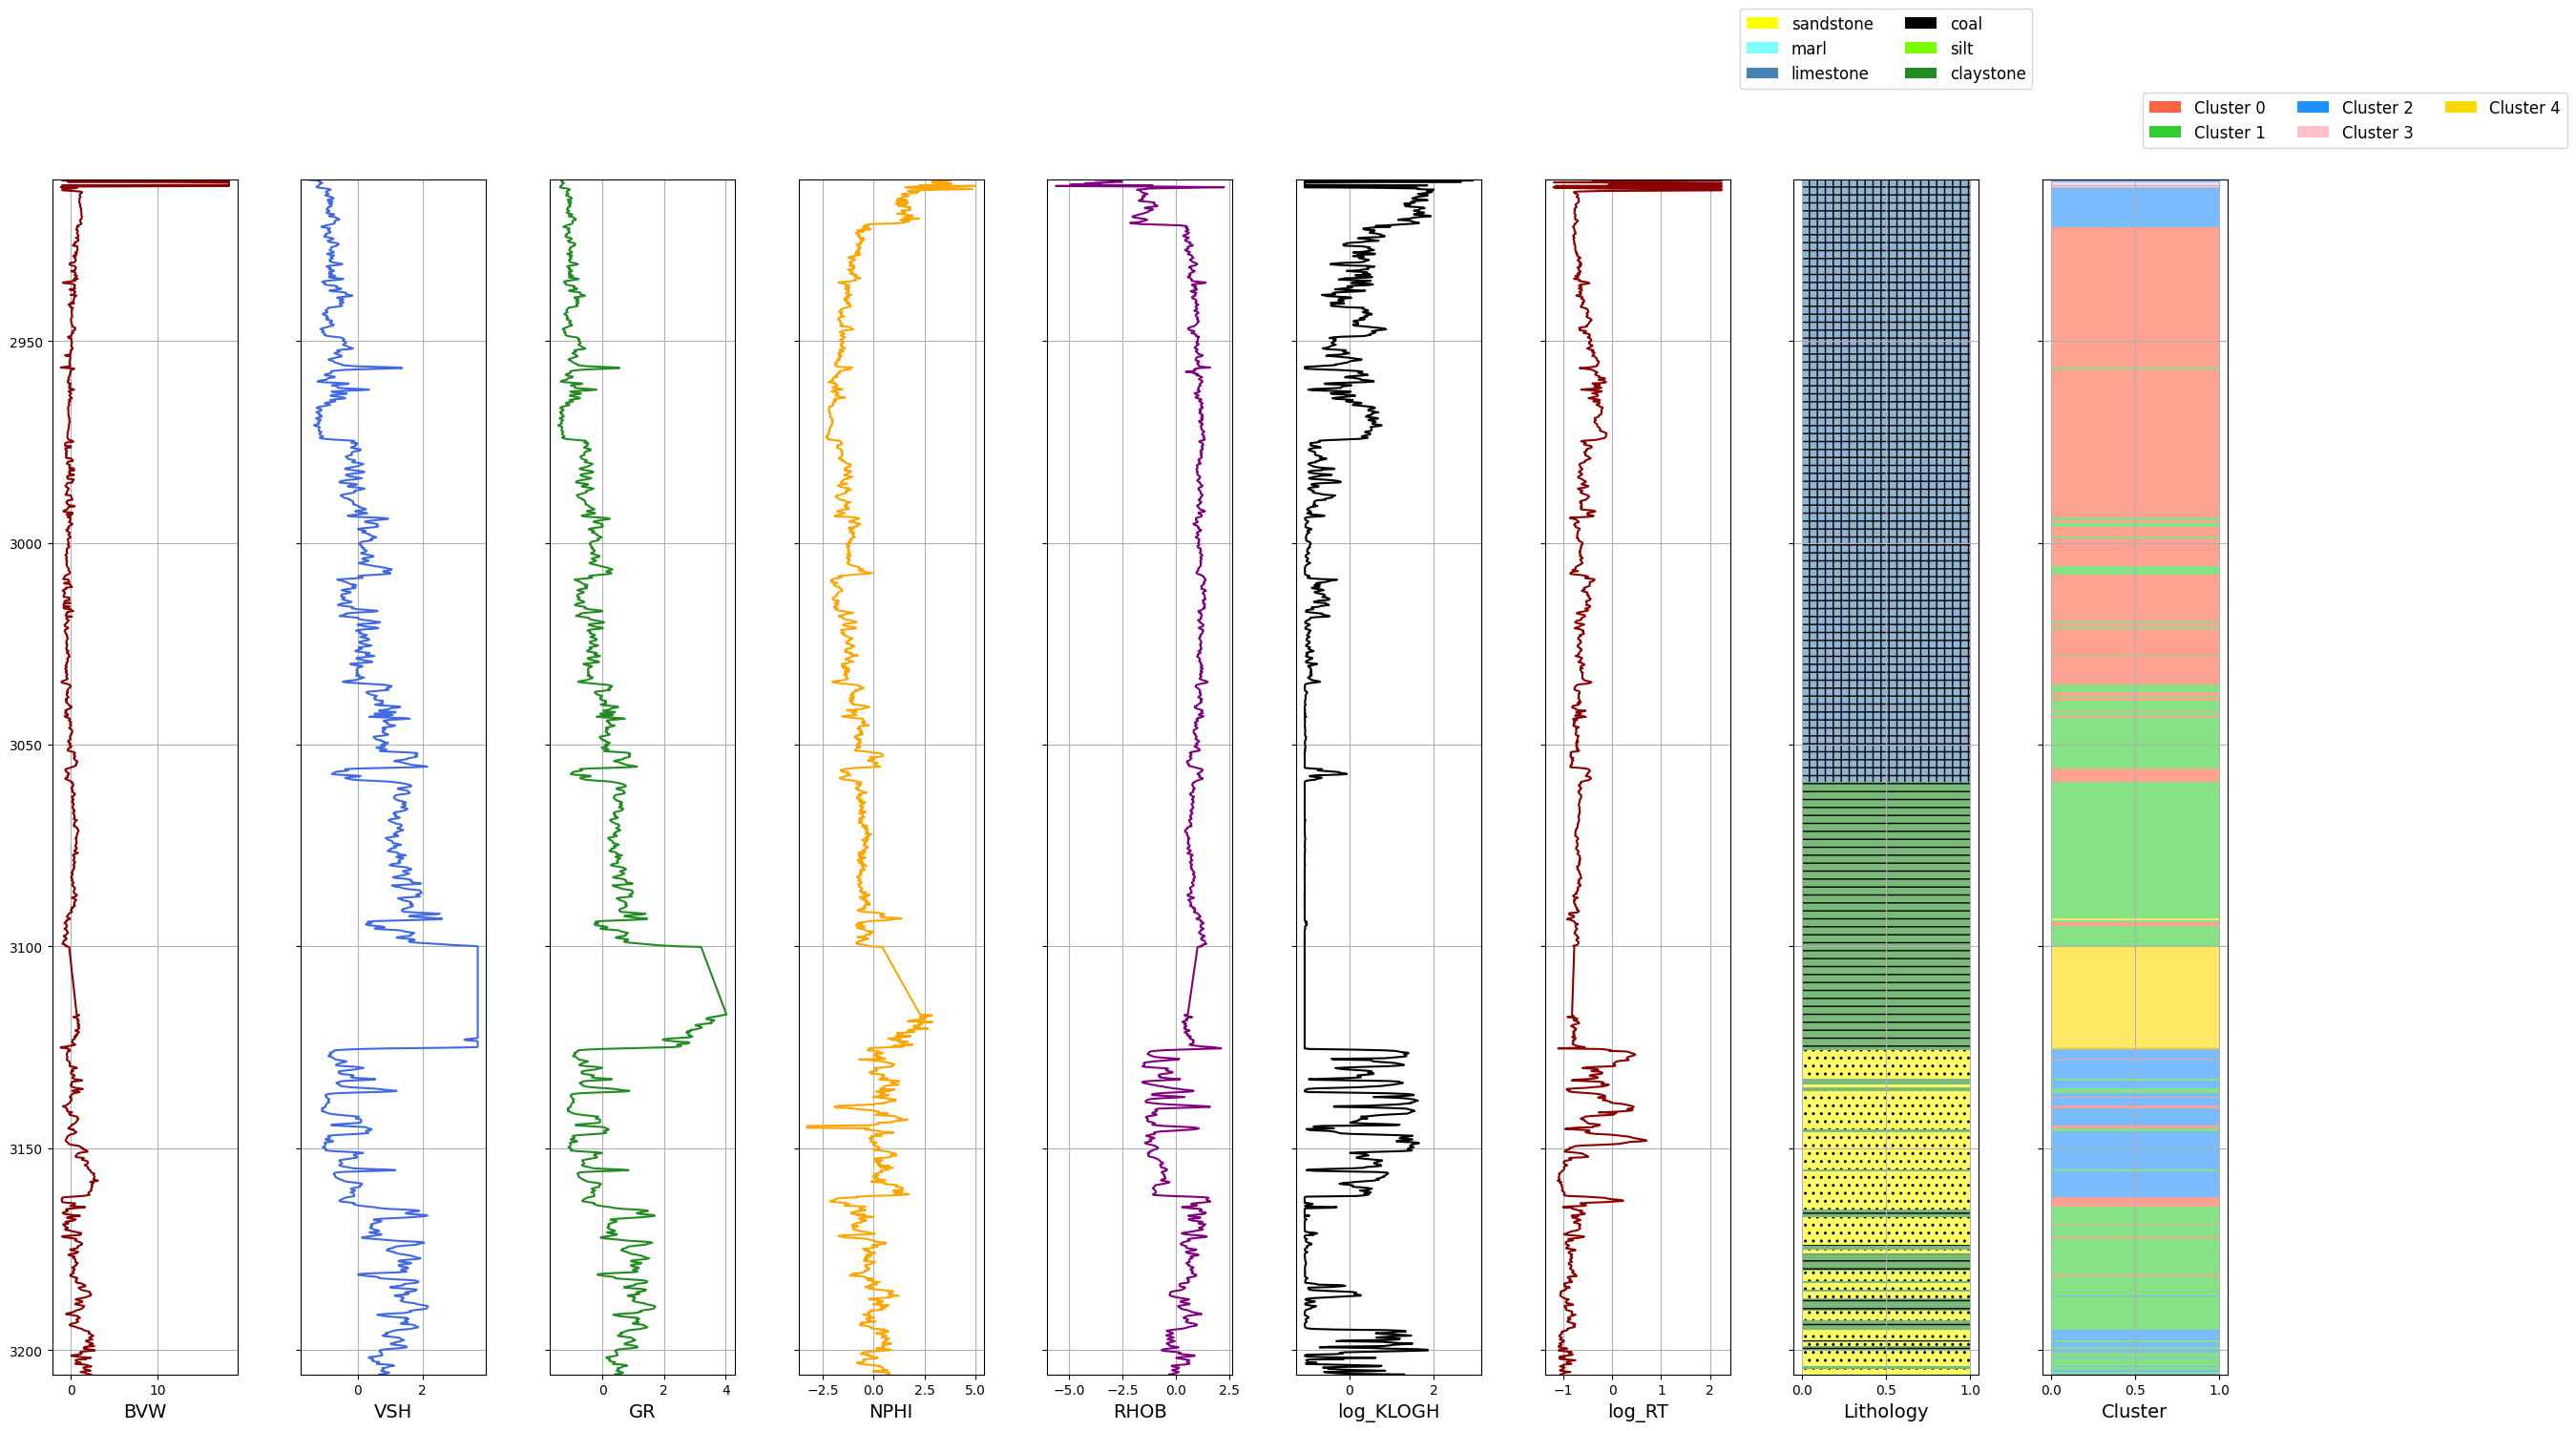

In [ ]:
train_clustered_list = [train_clustered_1, train_clustered_2, train_clustered_3, train_clustered_4, train_clustered_5]

for train_clusters in train_clustered_list:
  KMeans_Clustering.visualise_lithology_clusters(train_clusters, log_columns=column_names)


Next, we use the trained KMeans model to predict the clusters for the first well in our test dataset. This step involves applying the model we trained earlier to a new, unseen dataset, allowing us to evaluate how well the clustering generalises to other wells.

In [ ]:
standardised_test_well_data

[            DEPTH       BVW       VSH        GR      NPHI      RHOB  \
 0     3248.869698 -0.597169 -0.294024 -0.297633 -1.095170  1.830610   
 1     3249.022098 -0.707802 -0.294024 -0.531065 -1.606287  1.889379   
 2     3249.174498 -0.711683 -0.294024 -0.764497 -2.119119  1.301683   
 3     3249.326899 -0.711683 -0.294024 -0.619864 -1.951034  1.301683   
 4     3249.479299 -0.709743 -0.294024 -0.764497 -1.782948  1.301683   
 ...           ...       ...       ...       ...       ...       ...   
 3391  3765.659131  0.152030  0.775731  0.513606 -0.861908  0.829765   
 3392  3765.811532  0.501398  0.969523  0.679404 -0.546319  0.650518   
 3393  3765.963932  1.190428  0.953417  0.665636 -0.524022  0.483025   
 3394  3766.116332  0.928402  0.763262  0.502579 -0.168984  0.420729   
 3395  3766.268733  1.683424  0.673379  0.423299 -0.367943  0.243245   
 
       LITHOLOGY  log_KLOGH    log_RT  
 0          Marl  -1.063908 -0.650674  
 1          Marl  -1.063908 -0.547954  
 2          Ma

In [ ]:
test_clustered_1 = KMeans_Clustering.run_kmeans_test(standardised_test_well_data[0], kmeans_model)
test_clustered_2 = KMeans_Clustering.run_kmeans_test(standardised_test_well_data[1], kmeans_model)

Now that we have assigned clusters to the first test well, we can visualise the results. We’ll plot the clusters on a graph to see how well KMeans has identified the different lithologies in the well. This will create a visual representation of the clusters, making it easier to interpret the results and see how the KMeans algorithm has grouped the data.

In [ ]:
column_names = standardised_test_well_data[0].columns.tolist()
column_names = [col for col in column_names if col != "DEPTH"]
column_names = [col for col in column_names if col != "LITHOLOGY"]

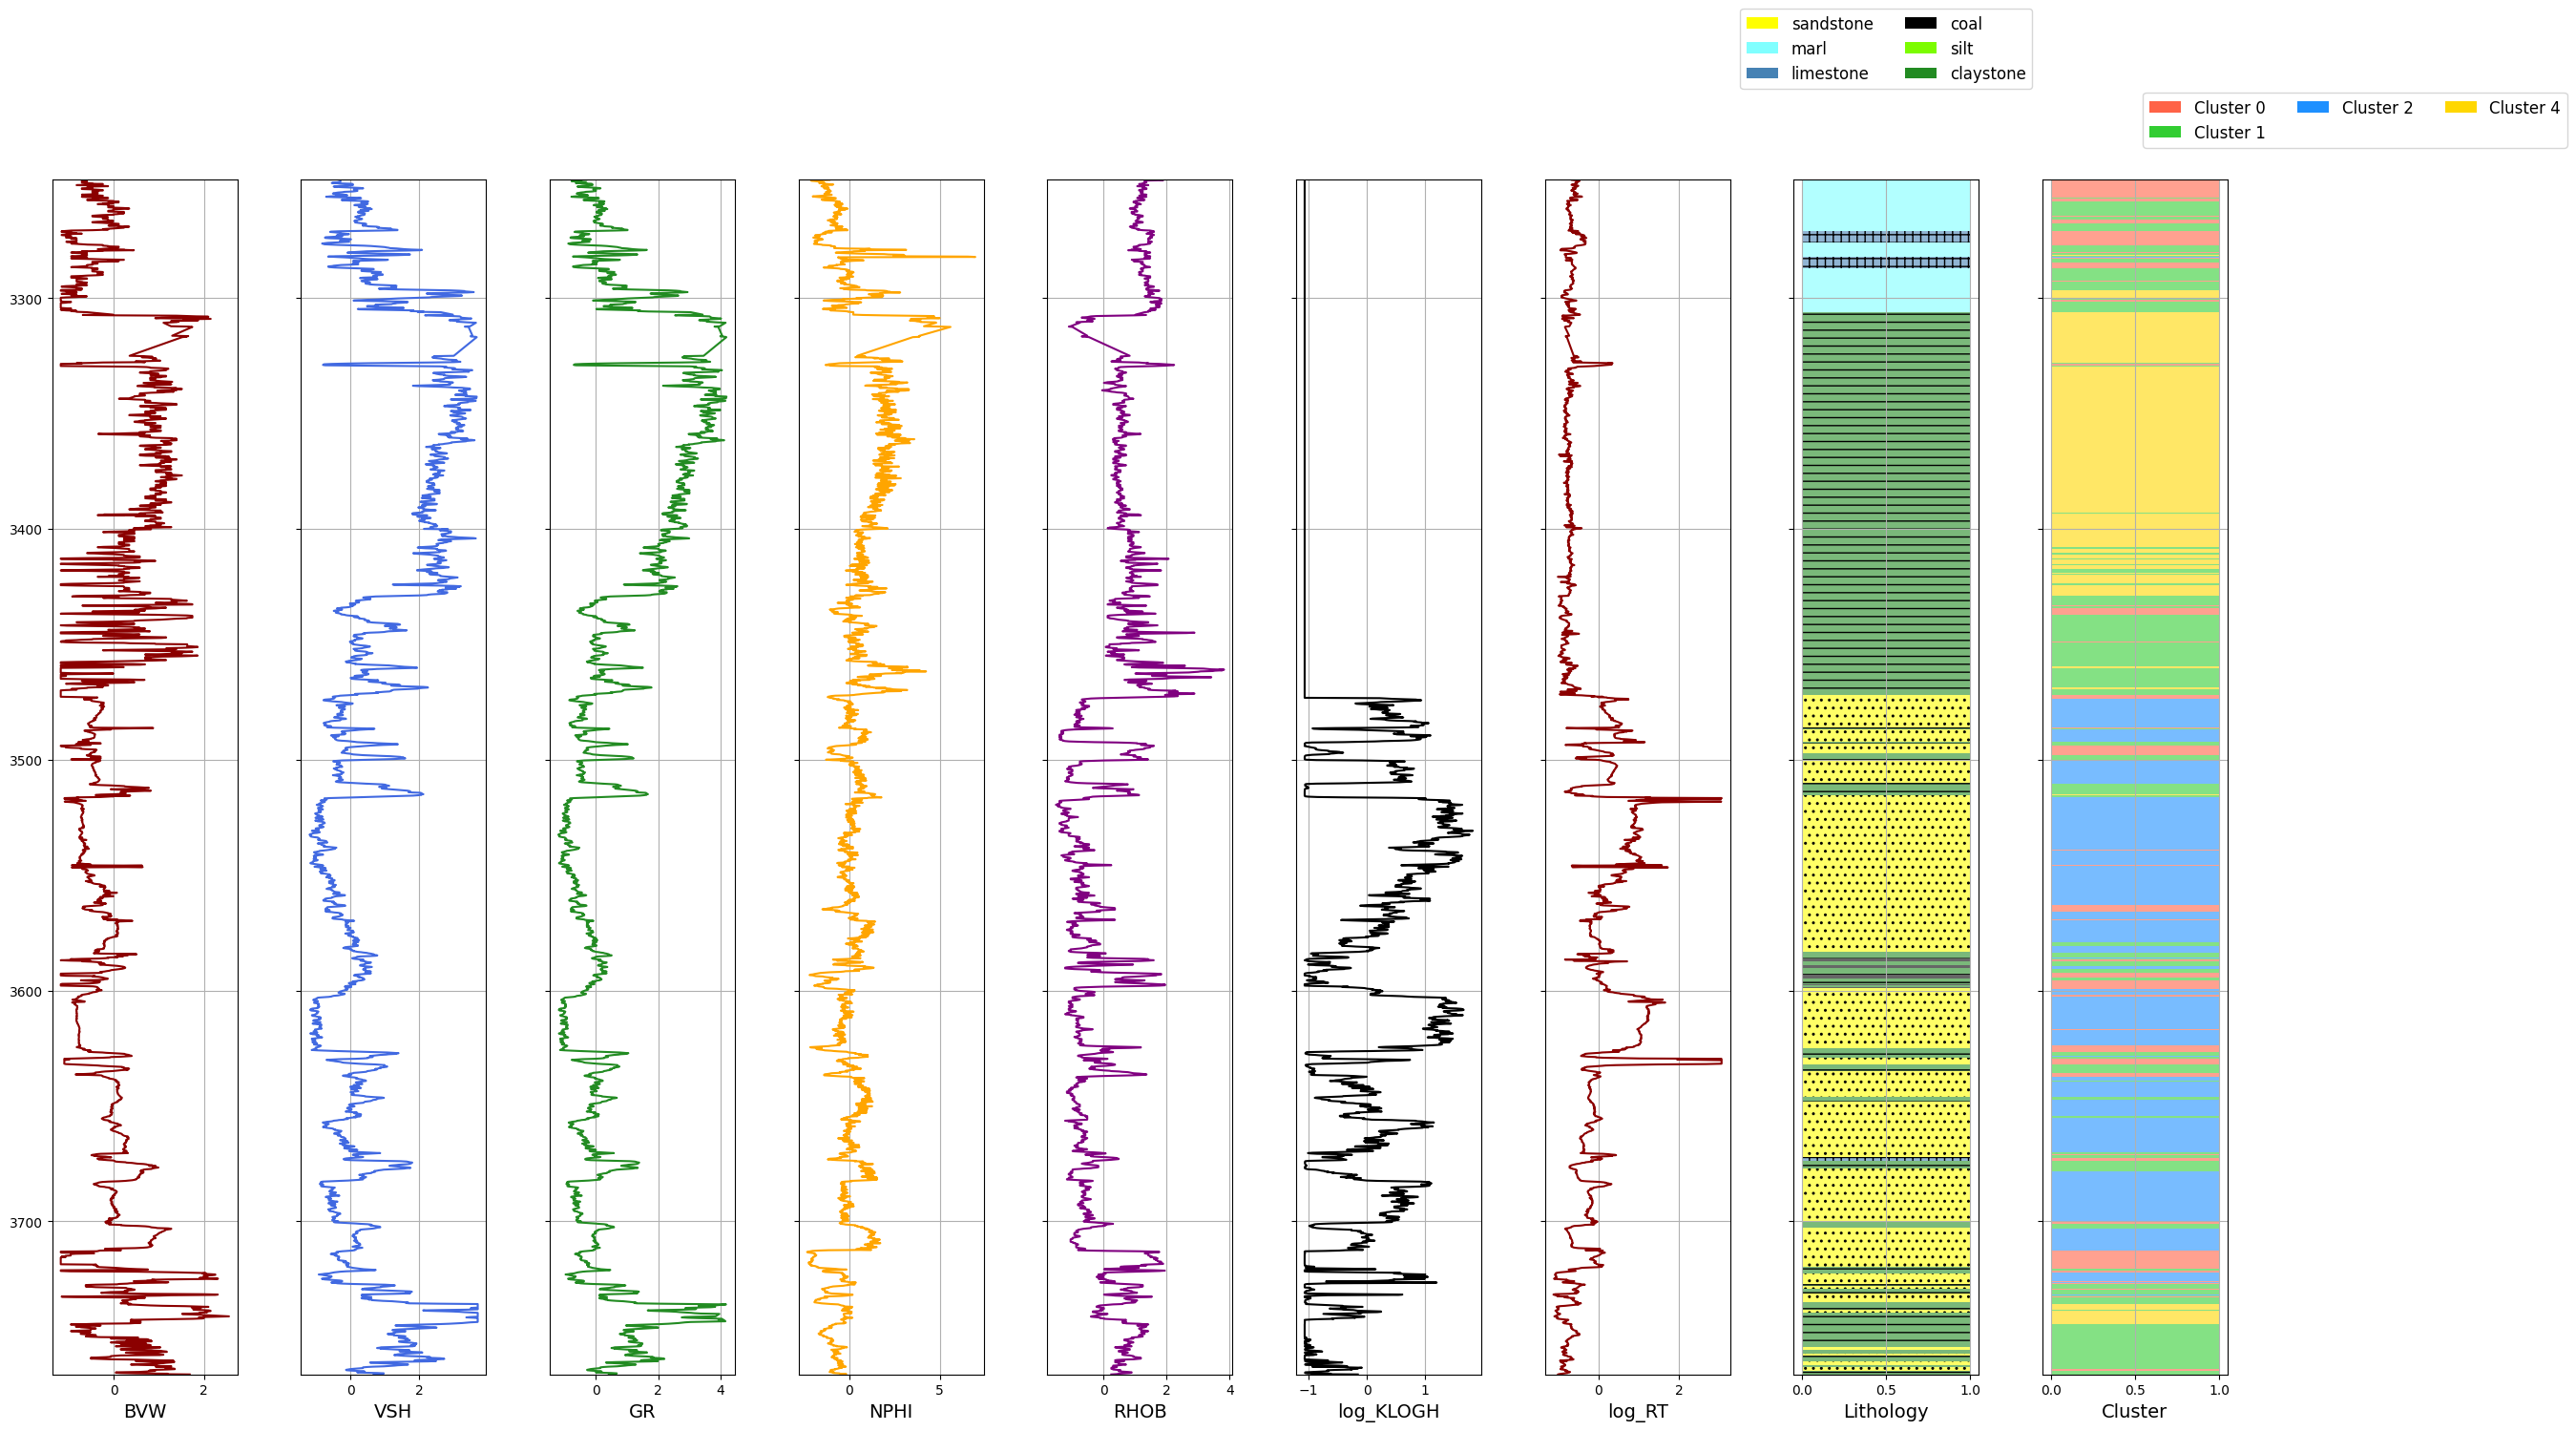

In [ ]:
KMeans_Clustering.visualise_lithology_clusters(test_clustered_1, log_columns=column_names)

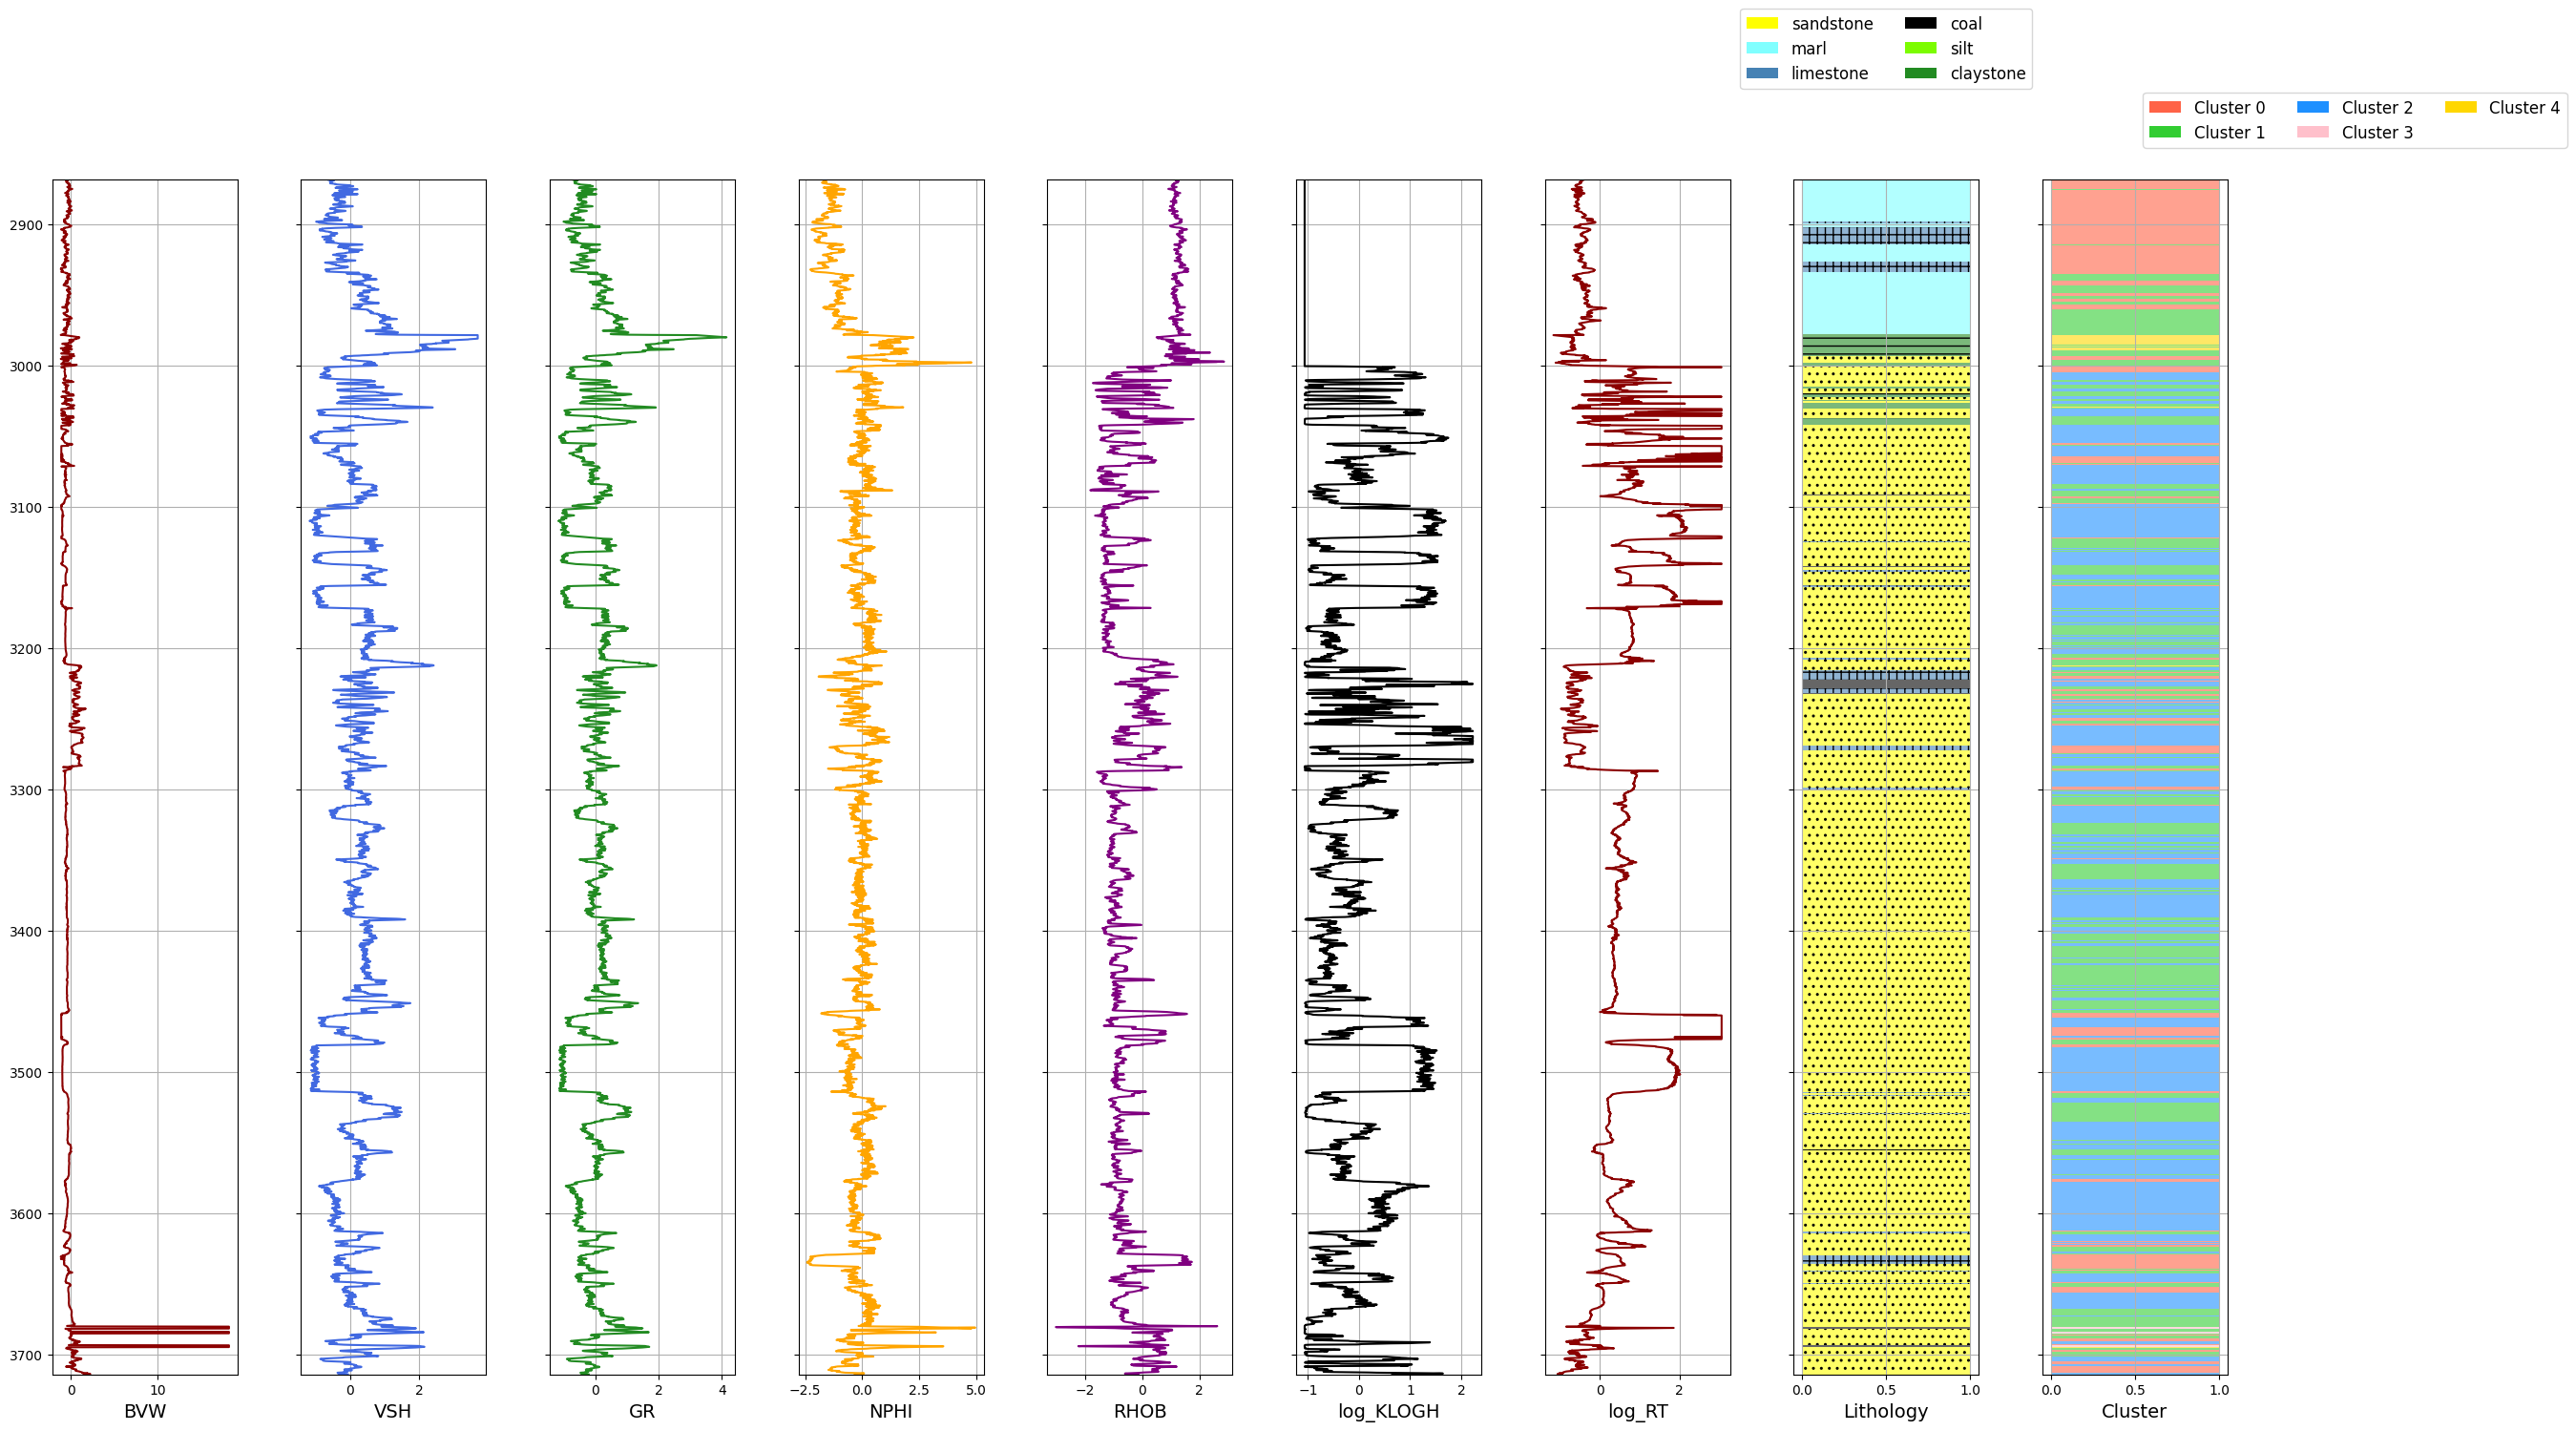

In [ ]:
KMeans_Clustering.visualise_lithology_clusters(test_clustered_2, log_columns=column_names)

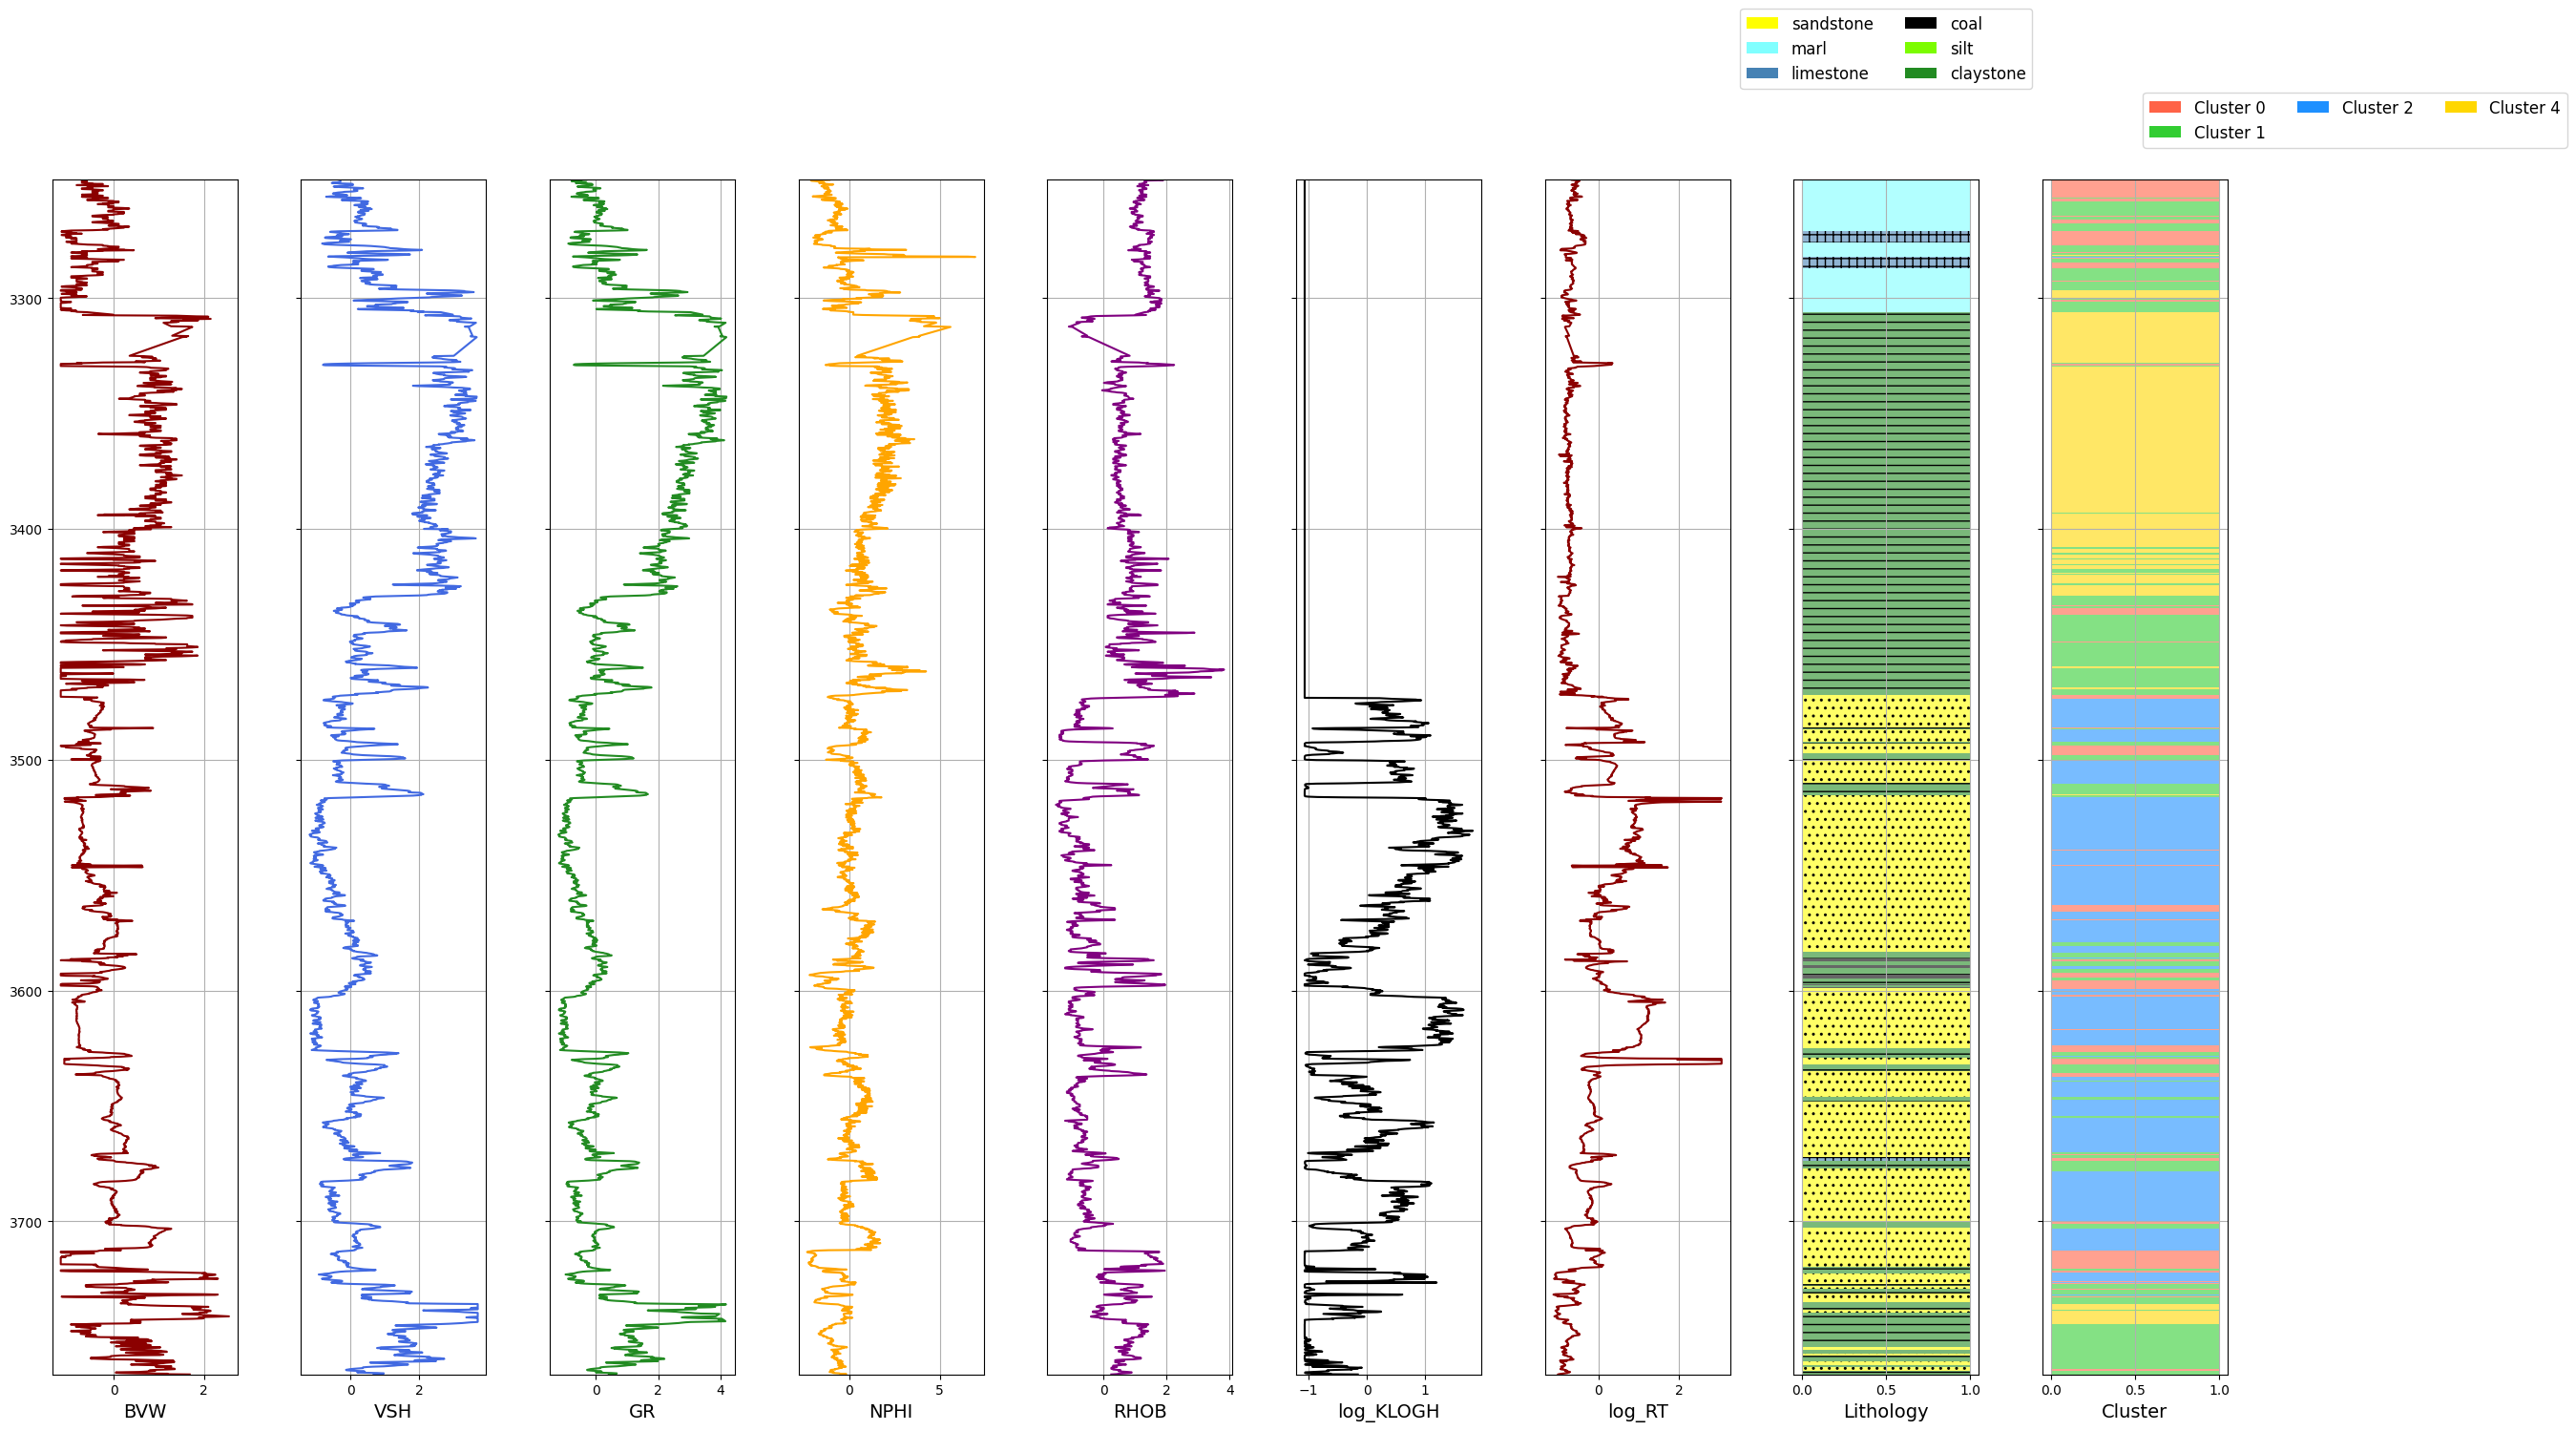

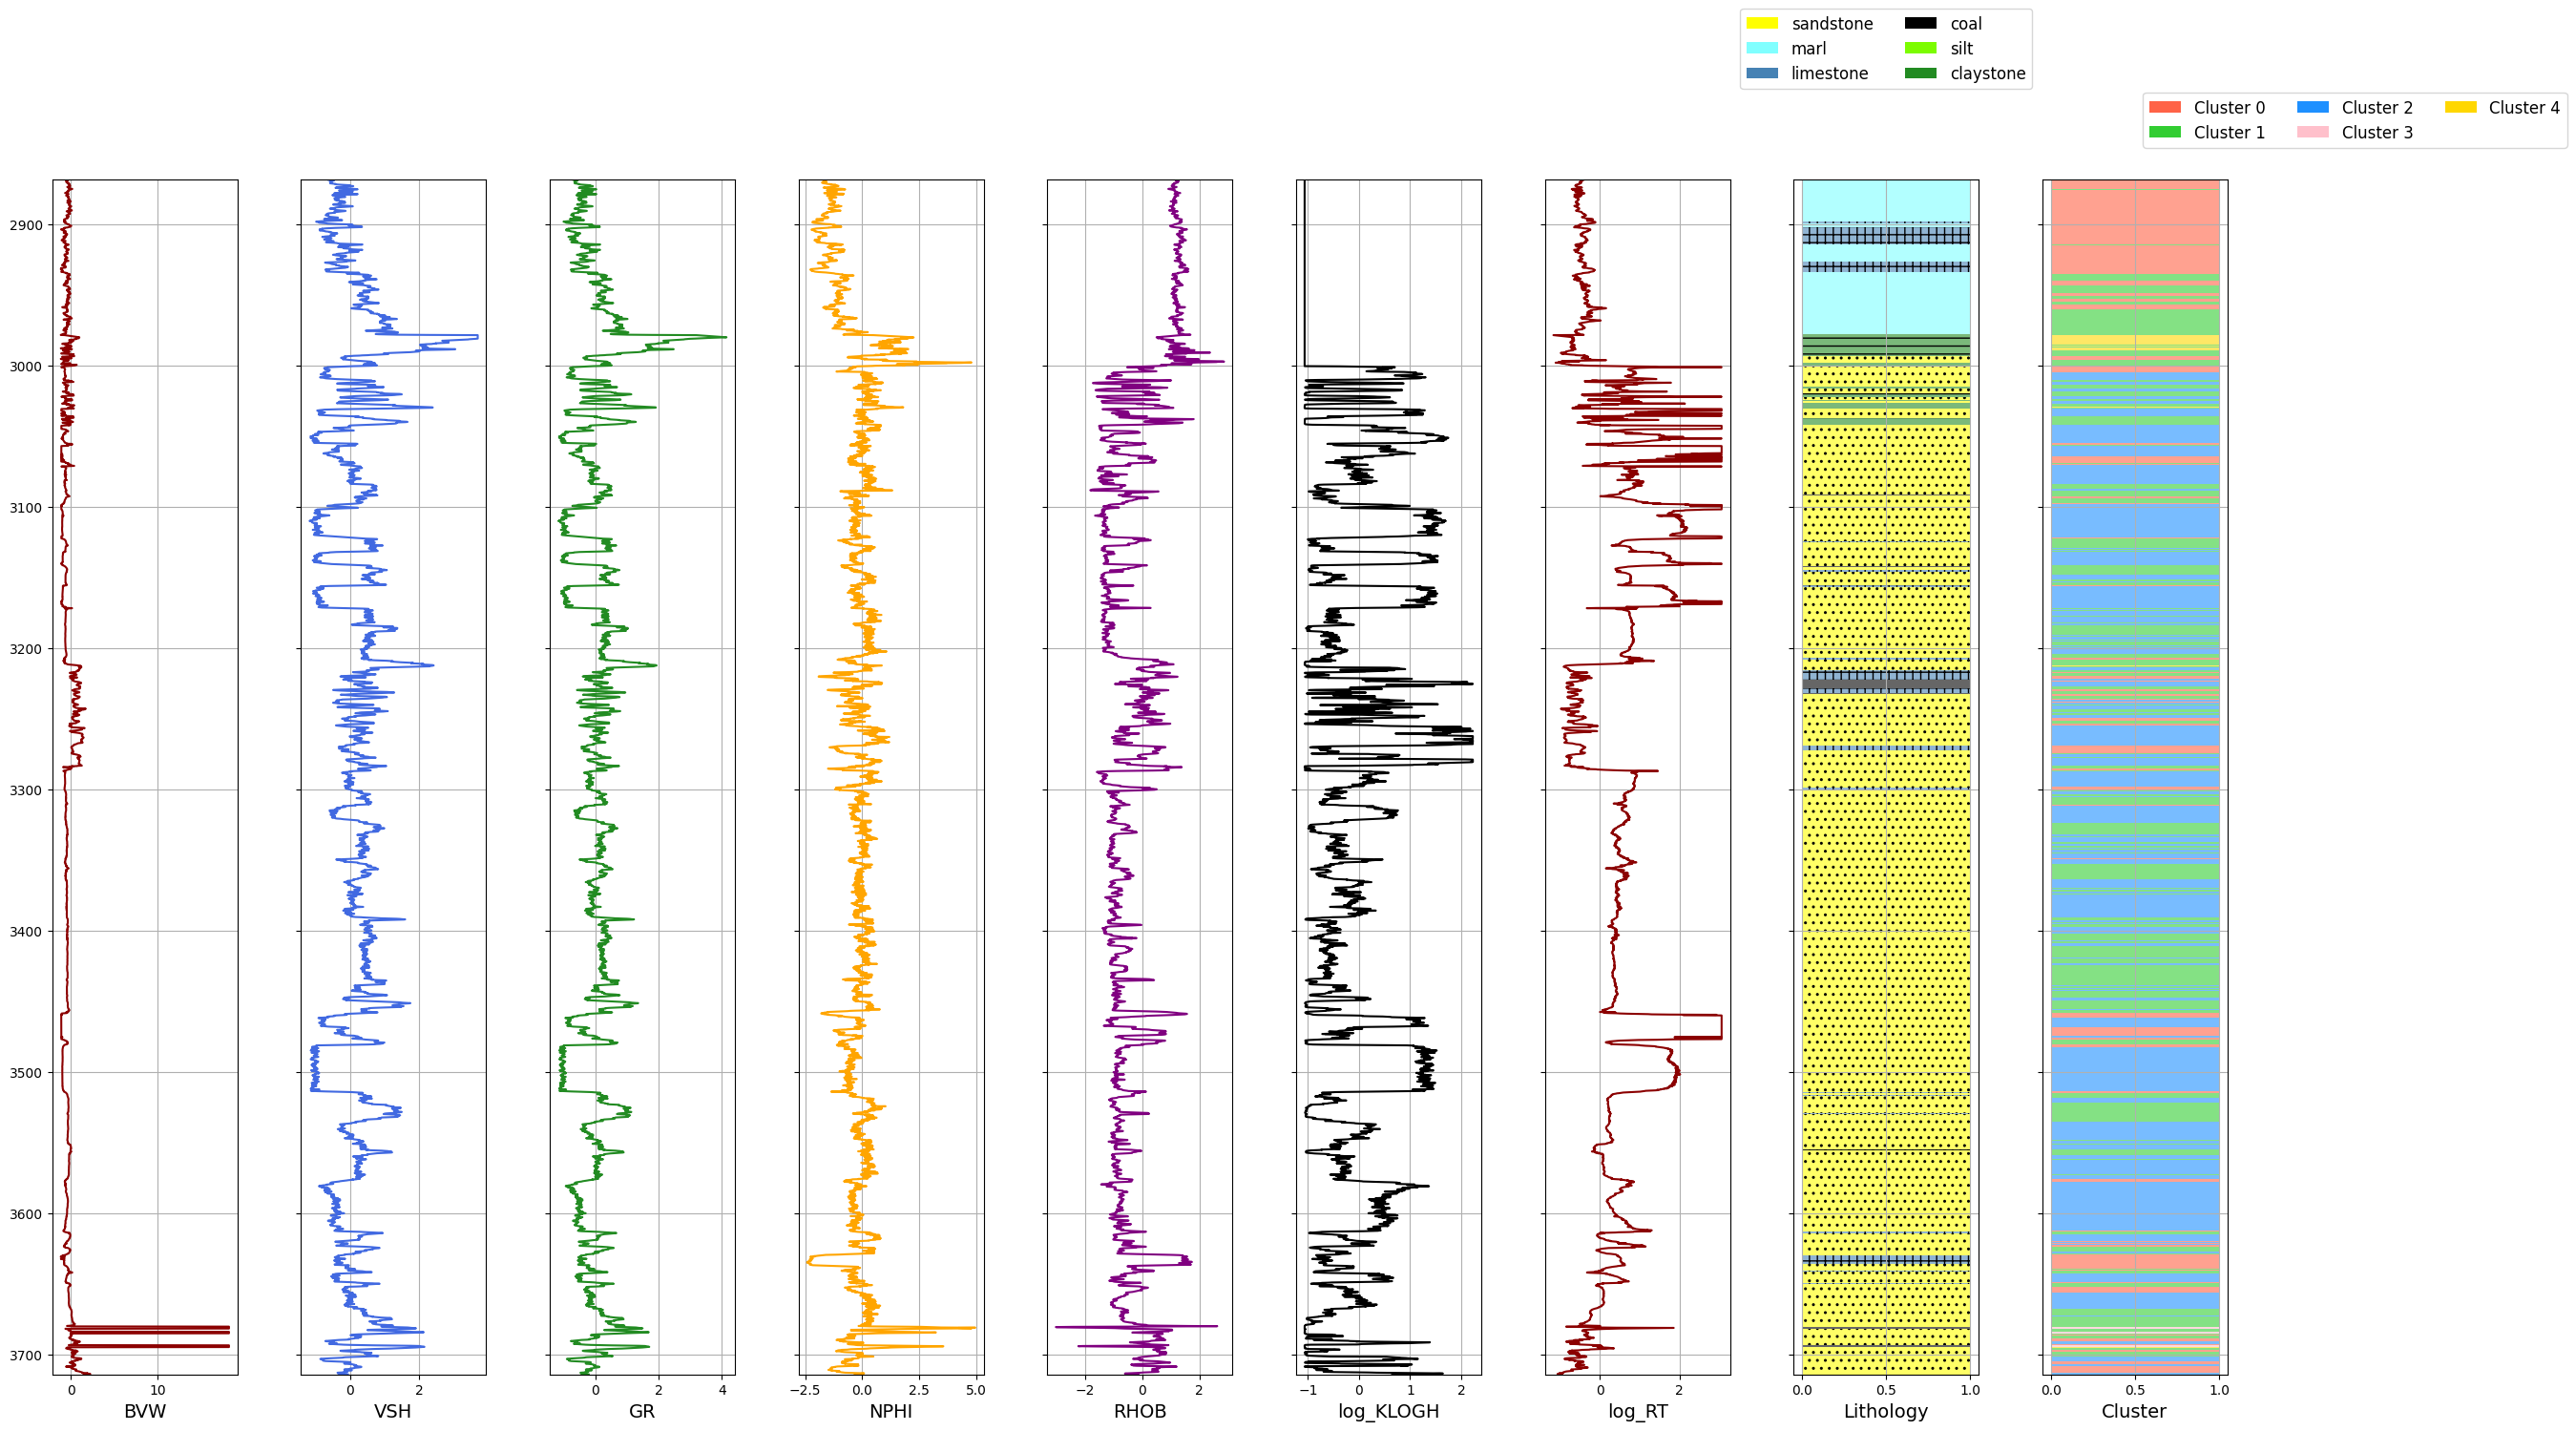

In [ ]:
test_clustered_list = [test_clustered_1, test_clustered_2]

for test_clusters in test_clustered_list:
  KMeans_Clustering.visualise_lithology_clusters(test_clusters, log_columns = column_names)

And finally, we can save the model for later use.

In [ ]:
from joblib import dump
from google.colab import drive

# Save the model to a file
dump(kmeans_model, 'kmeans_model.joblib')

# Save to Google Drive
drive.mount('/content/drive')
dump(kmeans_model, '/content/drive/MyDrive/kmeans_model.joblib')

Mounted at /content/drive


['/content/drive/MyDrive/kmeans_model.joblib']